In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
def get_titeseq_replicate_df(replicate_number='1'):

    data_df_full = pd.read_csv(f'data/replicate_{replicate_number}.csv',index_col=[0])
    y_cols = list(data_df_full.columns[14:58])
    cols = y_cols.copy()
    # Currently concatenating CDR1-H and CDR3-H sequencnes. Not sure if correct.
    data_df_full['x'] = (data_df_full['CDR1H_AA']+data_df_full['CDR3H_AA']).values
    cols.insert(0,'x')
    data_df = data_df_full[cols].copy()
    
    return data_df
    

In [3]:
replicate_1_df = get_titeseq_replicate_df('1')
replicate_2_df = get_titeseq_replicate_df('2')
replicate_3_df = get_titeseq_replicate_df('3')

data_df = replicate_1_df.append(replicate_2_df, ignore_index=True).append(replicate_3_df, ignore_index=True).reset_index(drop=True).copy()


In [4]:
data_df_full_rep_1 = pd.read_csv(f'data/replicate_1.csv',index_col=[0])
y_cols = list(data_df_full_rep_1.columns[14:58])
X = data_df['x']
y = data_df[y_cols]

In [5]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [6]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y',]


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=20, Y=44


In [7]:
#!ls /Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn/mavenn/development_mavenn2/Titeseq_16

In [8]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

# gpmap = mavenn.gpmap.Multi_AdditiveGPMapLayer(L=L, 
#                                               alphabet=alphabet,
#                                               number_latent_nodes=2)



2022-08-12 00:41:16.451027: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Initialize at discrete monotonic GP map

In [9]:
gpmap.set_params()
theta_0_init = np.load('models/theta_0_DM.npy')
theta_lc_init = np.load('models/theta_lc_DM.npy')

init_params_dict = {'theta_0':theta_0_init, 'theta_lc':theta_lc_init}
#gpmap.set_params(**init_params_dict)

In [10]:
# read in parameters

# number of reads in each bin summed
N_y = np.sum(y,axis=0)

In [11]:
print(N_y[0:10])

fluorescein0bin0          15885950
fluorescein0bin1            845949
fluorescein0bin2          14646947
fluorescein0bin3            480168
fluorescein10^-5.5bin0     4938811
fluorescein10^-5.5bin1     3558812
fluorescein10^-5.5bin2     7335952
fluorescein10^-5.5bin3     7306329
fluorescein10^-5bin0      12323072
fluorescein10^-5bin1       1386792
dtype: int64


#### I obtained these values from Fig 3's script

In [12]:
bin_vals_16_4_15 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.9683536647430646],
[2.96837636283699, 3.6663288893768895],
[3.6675170811229103, np.log10(3e4)]])

#April 19 gates
bin_vals_16_4_19 = np.array([[1.4775788014225415, 2.245106453825187],
[2.2459637507318497, 2.85027248745035],
[2.8650326346119392, 3.474446976276228],
[3.4849588153986915, np.log10(1e5)]])

#April 21 gates
bin_vals_16_4_21 = np.array([[1.4775788014225415,2.200826012340419],
[2.216443456408671,2.8355123402887603],
[2.8355123402887603,3.474446976276228],
[3.4849588153986915,np.log10(3e4)]])

aff_gates = [bin_vals_16_4_15, bin_vals_16_4_19, bin_vals_16_4_21]

In [13]:
np.mean(np.array(aff_gates),axis=0)

array([[1.4775788 , 2.23034631],
       [2.23612365, 2.88471283],
       [2.88964045, 3.53840761],
       [3.54581157, 4.65141417]])

In [14]:
#bounds = np.array([[0,180],[180,1400],[1400,10500],[10500,250000]])
bounds = np.mean(np.array(aff_gates),axis=0)
bounds_df = pd.DataFrame(bounds,columns=['lower_bound','upper_bound'])
f_y_lower_bounds = bounds_df['lower_bound'].values
f_y_upper_bounds = bounds_df['upper_bound'].values
bounds_df

,lower_bound,upper_bound
0,1.477579,2.230346
1,2.236124,2.884713
2,2.889640,3.538408
3,3.545812,4.651414


In [15]:
# mu_neg = np.log(200)
# mu_pos = np.log(9000)

#mu_neg = np.log(1.2)
mu_neg = np.log10(200)
#mu_neg = np.log(50)
mu_pos = np.log10(9000)

sigma_neg = 2.0
sigma_pos = 2.0

In [16]:
mu_neg, mu_pos

(2.3010299956639813, 3.9542425094393248)

In [17]:
np.log(20000), np.log(10)

(9.903487552536127, 2.302585092994046)

In [18]:
f_y_upper_bounds

array([2.23034631, 2.88471283, 3.53840761, 4.65141417])

In [19]:
replicate_1_df.columns

Index(['x', 'fluorescein0bin0', 'fluorescein0bin1', 'fluorescein0bin2',
       'fluorescein0bin3', 'fluorescein10^-5.5bin0', 'fluorescein10^-5.5bin1',
       'fluorescein10^-5.5bin2', 'fluorescein10^-5.5bin3',
       'fluorescein10^-5bin0', 'fluorescein10^-5bin1', 'fluorescein10^-5bin2',
       'fluorescein10^-5bin3', 'fluorescein10^-6.5bin0',
       'fluorescein10^-6.5bin1', 'fluorescein10^-6.5bin2',
       'fluorescein10^-6.5bin3', 'fluorescein10^-6bin0',
       'fluorescein10^-6bin1', 'fluorescein10^-6bin2', 'fluorescein10^-6bin3',
       'fluorescein10^-7.5bin0', 'fluorescein10^-7.5bin1',
       'fluorescein10^-7.5bin2', 'fluorescein10^-7.5bin3',
       'fluorescein10^-7bin0', 'fluorescein10^-7bin1', 'fluorescein10^-7bin2',
       'fluorescein10^-7bin3', 'fluorescein10^-8.5bin0',
       'fluorescein10^-8.5bin1', 'fluorescein10^-8.5bin2',
       'fluorescein10^-8.5bin3', 'fluorescein10^-8bin0',
       'fluorescein10^-8bin1', 'fluorescein10^-8bin2', 'fluorescein10^-8bin3',
       'fl

In [20]:
#np.arange(10**(-13),10**(-6),10**(-12))
cs = [0,10**(-9.5),
     10**(-9),10**(-8.5),
     10**(-8),10**(-7.5),
     10**(-7),10**(-6.5),
     10**(-6),10**(-5.5),
     10**(-5),]

cs2 = [0,10**(-5.5),
     10**(-5),10**(-6.5),
     10**(-6),10**(-7.5),
     10**(-7),10**(-8.5),
     10**(-8),10**(-9.5),
     10**(-9),]


In [21]:
TiteSeq_mp_list = [mavenn.measurement_process_layers.TiteSeqMP(N_y=N_y[4*mp_idx:4*mp_idx+4],
                                                         #c=cs[mp_idx],      
                                                         c=cs2[mp_idx],
                                                         Y=4,
                                                         mu_pos=mu_pos,
                                                         sigma_pos=sigma_pos,
                                                         mu_neg=mu_neg,
                                                         sigma_neg=sigma_neg,
                                                         f_y_lower_bounds=f_y_lower_bounds,
                                                         f_y_upper_bounds=f_y_upper_bounds,
                                                         info_for_layers_dict={'H_y_norm':0},
                                                         eta=1e-5,)
           for mp_idx in range(len(y_cols)//4)
          ]

In [22]:
len(TiteSeq_mp_list)

11

In [23]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=TiteSeq_mp_list)

In [24]:
#model.model.summary()

In [25]:
# Set training data
model.set_data(x=x_train,
               
               y_list=[
                       y_train[y_cols[0:4]].values,
                       y_train[y_cols[4:8]].values,
                       y_train[y_cols[8:12]].values,
                       y_train[y_cols[12:16]].values,
                       y_train[y_cols[16:20]].values,
                       y_train[y_cols[20:24]].values,
                       y_train[y_cols[24:28]].values,
                       y_train[y_cols[28:32]].values,
                       y_train[y_cols[32:36]].values,
                       y_train[y_cols[36:40]].values,
                       y_train[y_cols[40:44]].values,                                                        
                      ],

               shuffle=False)

N = 10,487 observations set as training data.
Using 20.7% for validation.
Time to set data: 0.374 sec.


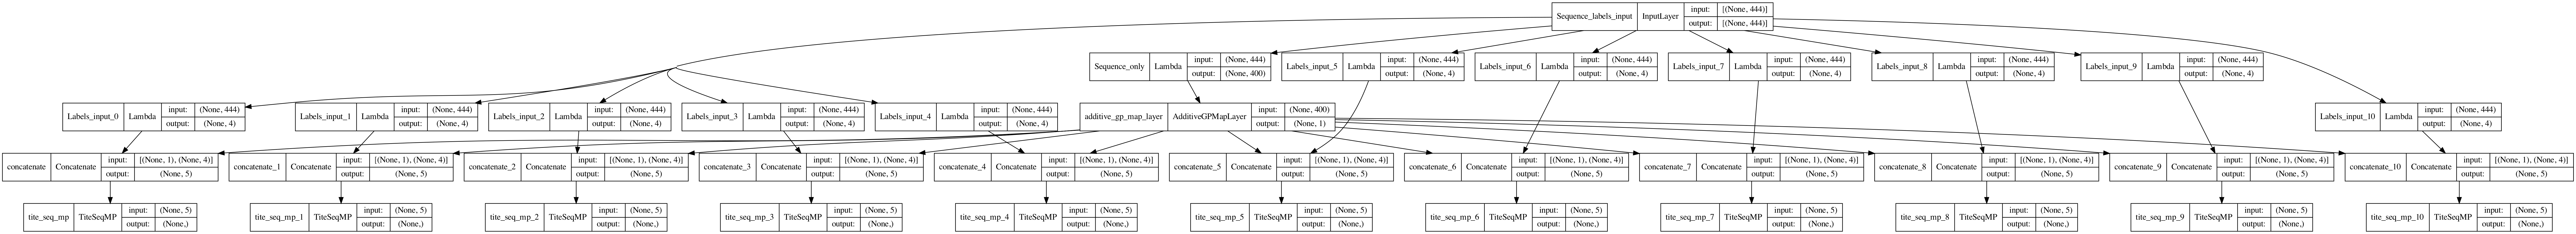

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200,to_file='pngs/Titeseq_MP/titeseq16_TSMP.png')


In [27]:

# Fit model to data
model.fit(learning_rate=.0007,
          epochs=600,
          batch_size=200,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=200,
          linear_initialization=False)

Epoch 1/600
42/42 [==============================] - 9s 39ms/step - loss: 7083949.0000 - tite_seq_mp_loss: 500844.1875 - tite_seq_mp_1_loss: 589890.1250 - tite_seq_mp_2_loss: 965548.6875 - tite_seq_mp_3_loss: 607935.4375 - tite_seq_mp_4_loss: 481379.4688 - tite_seq_mp_5_loss: 292347.5000 - tite_seq_mp_6_loss: 352060.1875 - tite_seq_mp_7_loss: 970982.8750 - tite_seq_mp_8_loss: 616442.3125 - tite_seq_mp_9_loss: 911380.5000 - tite_seq_mp_10_loss: 795137.7500 - I_var: -0.1140 - val_loss: 7078550.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 677183.7500 - val_tite_seq_mp_2_loss: 1180626.8750 - val_tite_seq_mp_3_loss: 975863.3750 - val_tite_seq_mp_4_loss: 582919.0625 - val_tite_seq_mp_5_loss: 199475.6406 - val_tite_seq_mp_6_loss: 257215.3281 - val_tite_seq_mp_7_loss: 630853.3125 - val_tite_seq_mp_8_loss: 535075.8750 - val_tite_seq_mp_9_loss: 738285.1250 - val_tite_seq_mp_10_loss: 691839.4375 - val_I_var: -0.1000
Epoch 2/600
42/42 [==============================] - 0s 7ms

Epoch 10/600
42/42 [==============================] - 0s 6ms/step - loss: 7076676.5000 - tite_seq_mp_loss: 500543.0938 - tite_seq_mp_1_loss: 589237.2500 - tite_seq_mp_2_loss: 963875.6250 - tite_seq_mp_3_loss: 607229.3750 - tite_seq_mp_4_loss: 480848.2188 - tite_seq_mp_5_loss: 292240.9688 - tite_seq_mp_6_loss: 351820.7188 - tite_seq_mp_7_loss: 970770.9375 - tite_seq_mp_8_loss: 616025.5000 - tite_seq_mp_9_loss: 909689.7500 - tite_seq_mp_10_loss: 794395.8125 - I_var: -0.1152 - val_loss: 7076320.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 676512.1250 - val_tite_seq_mp_2_loss: 1179746.8750 - val_tite_seq_mp_3_loss: 975475.7500 - val_tite_seq_mp_4_loss: 582658.3125 - val_tite_seq_mp_5_loss: 199472.3438 - val_tite_seq_mp_6_loss: 257192.4219 - val_tite_seq_mp_7_loss: 630852.4375 - val_tite_seq_mp_8_loss: 535073.7500 - val_tite_seq_mp_9_loss: 738284.8750 - val_tite_seq_mp_10_loss: 691839.1875 - val_I_var: -0.1000
Epoch 11/600
42/42 [==============================] - 0s 6m

Epoch 19/600
42/42 [==============================] - 0s 6ms/step - loss: 7063892.0000 - tite_seq_mp_loss: 500412.1875 - tite_seq_mp_1_loss: 587778.6250 - tite_seq_mp_2_loss: 962305.0625 - tite_seq_mp_3_loss: 605448.0625 - tite_seq_mp_4_loss: 479604.4688 - tite_seq_mp_5_loss: 291486.6250 - tite_seq_mp_6_loss: 350855.3750 - tite_seq_mp_7_loss: 968033.1250 - tite_seq_mp_8_loss: 614459.8750 - tite_seq_mp_9_loss: 909915.6875 - tite_seq_mp_10_loss: 793592.5000 - I_var: -0.1122 - val_loss: 7067598.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 675589.0625 - val_tite_seq_mp_2_loss: 1179230.3750 - val_tite_seq_mp_3_loss: 971631.1875 - val_tite_seq_mp_4_loss: 581963.0625 - val_tite_seq_mp_5_loss: 199236.8594 - val_tite_seq_mp_6_loss: 256496.5781 - val_tite_seq_mp_7_loss: 630305.8125 - val_tite_seq_mp_8_loss: 534566.9375 - val_tite_seq_mp_9_loss: 737900.8125 - val_tite_seq_mp_10_loss: 691465.3750 - val_I_var: -0.0994
Epoch 20/600
42/42 [==============================] - 0s 6m

Epoch 28/600
42/42 [==============================] - 0s 6ms/step - loss: 7057379.0000 - tite_seq_mp_loss: 500376.5312 - tite_seq_mp_1_loss: 587842.3125 - tite_seq_mp_2_loss: 962021.3125 - tite_seq_mp_3_loss: 605428.1250 - tite_seq_mp_4_loss: 479836.2812 - tite_seq_mp_5_loss: 291615.1250 - tite_seq_mp_6_loss: 350700.5938 - tite_seq_mp_7_loss: 967362.9375 - tite_seq_mp_8_loss: 613951.1875 - tite_seq_mp_9_loss: 905395.5625 - tite_seq_mp_10_loss: 792849.5000 - I_var: -0.1105 - val_loss: 7059017.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 674998.1875 - val_tite_seq_mp_2_loss: 1178783.2500 - val_tite_seq_mp_3_loss: 970166.3125 - val_tite_seq_mp_4_loss: 581719.5625 - val_tite_seq_mp_5_loss: 199181.7969 - val_tite_seq_mp_6_loss: 256205.8281 - val_tite_seq_mp_7_loss: 629834.4375 - val_tite_seq_mp_8_loss: 534405.8125 - val_tite_seq_mp_9_loss: 734030.1250 - val_tite_seq_mp_10_loss: 690480.1250 - val_I_var: -0.0984
Epoch 29/600
42/42 [==============================] - 0s 6m

Epoch 37/600
42/42 [==============================] - 0s 6ms/step - loss: 7049206.0000 - tite_seq_mp_loss: 500825.1875 - tite_seq_mp_1_loss: 587139.5000 - tite_seq_mp_2_loss: 961071.9375 - tite_seq_mp_3_loss: 605148.8125 - tite_seq_mp_4_loss: 479765.6562 - tite_seq_mp_5_loss: 291084.7500 - tite_seq_mp_6_loss: 350265.5000 - tite_seq_mp_7_loss: 965918.5000 - tite_seq_mp_8_loss: 613593.6250 - tite_seq_mp_9_loss: 902228.3750 - tite_seq_mp_10_loss: 792165.5625 - I_var: -0.1123 - val_loss: 7051399.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 674196.3125 - val_tite_seq_mp_2_loss: 1178184.3750 - val_tite_seq_mp_3_loss: 968292.8750 - val_tite_seq_mp_4_loss: 581413.2500 - val_tite_seq_mp_5_loss: 199099.0156 - val_tite_seq_mp_6_loss: 255823.9219 - val_tite_seq_mp_7_loss: 629567.0625 - val_tite_seq_mp_8_loss: 534203.3125 - val_tite_seq_mp_9_loss: 731390.0000 - val_tite_seq_mp_10_loss: 690016.3125 - val_I_var: -0.0979
Epoch 38/600
42/42 [==============================] - 0s 6m

Epoch 46/600
42/42 [==============================] - 0s 5ms/step - loss: 7038010.0000 - tite_seq_mp_loss: 500480.2500 - tite_seq_mp_1_loss: 586337.1250 - tite_seq_mp_2_loss: 960027.5625 - tite_seq_mp_3_loss: 604010.9375 - tite_seq_mp_4_loss: 479052.6250 - tite_seq_mp_5_loss: 290876.9062 - tite_seq_mp_6_loss: 349694.8750 - tite_seq_mp_7_loss: 963919.3125 - tite_seq_mp_8_loss: 612851.3750 - tite_seq_mp_9_loss: 899427.1250 - tite_seq_mp_10_loss: 791331.6250 - I_var: -0.1106 - val_loss: 7041819.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 673113.1250 - val_tite_seq_mp_2_loss: 1177395.7500 - val_tite_seq_mp_3_loss: 965848.9375 - val_tite_seq_mp_4_loss: 581032.8750 - val_tite_seq_mp_5_loss: 198984.4531 - val_tite_seq_mp_6_loss: 255312.4844 - val_tite_seq_mp_7_loss: 629222.7500 - val_tite_seq_mp_8_loss: 533907.8125 - val_tite_seq_mp_9_loss: 728344.2500 - val_tite_seq_mp_10_loss: 689443.6875 - val_I_var: -0.0970
Epoch 47/600
42/42 [==============================] - 0s 6m

Epoch 55/600
42/42 [==============================] - 0s 6ms/step - loss: 7030459.0000 - tite_seq_mp_loss: 500682.6250 - tite_seq_mp_1_loss: 585603.7500 - tite_seq_mp_2_loss: 959499.3750 - tite_seq_mp_3_loss: 603064.2500 - tite_seq_mp_4_loss: 478909.7812 - tite_seq_mp_5_loss: 290933.7500 - tite_seq_mp_6_loss: 349197.4062 - tite_seq_mp_7_loss: 964607.0000 - tite_seq_mp_8_loss: 612253.2500 - tite_seq_mp_9_loss: 895042.1875 - tite_seq_mp_10_loss: 790666.0625 - I_var: -0.1100 - val_loss: 7029073.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 671616.4375 - val_tite_seq_mp_2_loss: 1176323.0000 - val_tite_seq_mp_3_loss: 962509.5000 - val_tite_seq_mp_4_loss: 580540.1875 - val_tite_seq_mp_5_loss: 198825.0625 - val_tite_seq_mp_6_loss: 254603.7656 - val_tite_seq_mp_7_loss: 628792.0625 - val_tite_seq_mp_8_loss: 533496.6875 - val_tite_seq_mp_9_loss: 724450.8125 - val_tite_seq_mp_10_loss: 688703.9375 - val_I_var: -0.0958
Epoch 56/600
42/42 [==============================] - 0s 6m

Epoch 64/600
42/42 [==============================] - 0s 6ms/step - loss: 7010308.5000 - tite_seq_mp_loss: 500372.4688 - tite_seq_mp_1_loss: 584251.9375 - tite_seq_mp_2_loss: 957582.5625 - tite_seq_mp_3_loss: 601457.6875 - tite_seq_mp_4_loss: 478245.3438 - tite_seq_mp_5_loss: 290320.7812 - tite_seq_mp_6_loss: 347906.5625 - tite_seq_mp_7_loss: 962831.7500 - tite_seq_mp_8_loss: 610580.6250 - tite_seq_mp_9_loss: 888183.2500 - tite_seq_mp_10_loss: 788575.3750 - I_var: -0.1064 - val_loss: 7012187.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 669579.5625 - val_tite_seq_mp_2_loss: 1174878.6250 - val_tite_seq_mp_3_loss: 957929.3125 - val_tite_seq_mp_4_loss: 579900.4375 - val_tite_seq_mp_5_loss: 198616.0000 - val_tite_seq_mp_6_loss: 253627.0156 - val_tite_seq_mp_7_loss: 628276.1875 - val_tite_seq_mp_8_loss: 532972.3125 - val_tite_seq_mp_9_loss: 719431.0000 - val_tite_seq_mp_10_loss: 687763.3750 - val_I_var: -0.0942
Epoch 65/600
42/42 [==============================] - 0s 6m

Epoch 73/600
42/42 [==============================] - 0s 6ms/step - loss: 6989732.0000 - tite_seq_mp_loss: 500450.0000 - tite_seq_mp_1_loss: 581971.8750 - tite_seq_mp_2_loss: 954931.5000 - tite_seq_mp_3_loss: 599067.0000 - tite_seq_mp_4_loss: 477509.2812 - tite_seq_mp_5_loss: 289794.3125 - tite_seq_mp_6_loss: 346561.7812 - tite_seq_mp_7_loss: 960516.1250 - tite_seq_mp_8_loss: 609355.8125 - tite_seq_mp_9_loss: 881562.5000 - tite_seq_mp_10_loss: 788011.6875 - I_var: -0.1061 - val_loss: 6988909.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 666732.0000 - val_tite_seq_mp_2_loss: 1172853.6250 - val_tite_seq_mp_3_loss: 951363.6250 - val_tite_seq_mp_4_loss: 579014.2500 - val_tite_seq_mp_5_loss: 198344.5156 - val_tite_seq_mp_6_loss: 252282.4219 - val_tite_seq_mp_7_loss: 627620.5625 - val_tite_seq_mp_8_loss: 532307.7500 - val_tite_seq_mp_9_loss: 712672.0625 - val_tite_seq_mp_10_loss: 686506.0000 - val_I_var: -0.0922
Epoch 74/600
42/42 [==============================] - 0s 6m

Epoch 82/600
42/42 [==============================] - 0s 6ms/step - loss: 6960729.0000 - tite_seq_mp_loss: 500456.5625 - tite_seq_mp_1_loss: 579892.5625 - tite_seq_mp_2_loss: 951263.3750 - tite_seq_mp_3_loss: 596450.0000 - tite_seq_mp_4_loss: 476568.5625 - tite_seq_mp_5_loss: 289249.6562 - tite_seq_mp_6_loss: 344781.0938 - tite_seq_mp_7_loss: 958542.3750 - tite_seq_mp_8_loss: 607306.9375 - tite_seq_mp_9_loss: 870788.8125 - tite_seq_mp_10_loss: 785429.0000 - I_var: -0.1037 - val_loss: 6959708.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 663117.5000 - val_tite_seq_mp_2_loss: 1170242.3750 - val_tite_seq_mp_3_loss: 942674.3750 - val_tite_seq_mp_4_loss: 577896.1875 - val_tite_seq_mp_5_loss: 198006.8125 - val_tite_seq_mp_6_loss: 250597.1406 - val_tite_seq_mp_7_loss: 626843.5625 - val_tite_seq_mp_8_loss: 531482.5000 - val_tite_seq_mp_9_loss: 704686.3125 - val_tite_seq_mp_10_loss: 684948.8125 - val_I_var: -0.0897
Epoch 83/600
42/42 [==============================] - 0s 6m

Epoch 91/600
42/42 [==============================] - 0s 6ms/step - loss: 6930426.5000 - tite_seq_mp_loss: 500663.8125 - tite_seq_mp_1_loss: 576531.4375 - tite_seq_mp_2_loss: 947174.8750 - tite_seq_mp_3_loss: 591812.6250 - tite_seq_mp_4_loss: 475400.4062 - tite_seq_mp_5_loss: 288597.4688 - tite_seq_mp_6_loss: 342845.4375 - tite_seq_mp_7_loss: 956647.7500 - tite_seq_mp_8_loss: 605199.8125 - tite_seq_mp_9_loss: 861771.4375 - tite_seq_mp_10_loss: 783780.8125 - I_var: -0.0988 - val_loss: 6921484.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 658300.7500 - val_tite_seq_mp_2_loss: 1166650.5000 - val_tite_seq_mp_3_loss: 930655.0000 - val_tite_seq_mp_4_loss: 576376.7500 - val_tite_seq_mp_5_loss: 197565.4375 - val_tite_seq_mp_6_loss: 248492.3594 - val_tite_seq_mp_7_loss: 625843.3750 - val_tite_seq_mp_8_loss: 530423.8125 - val_tite_seq_mp_9_loss: 695078.9375 - val_tite_seq_mp_10_loss: 682884.5625 - val_I_var: -0.0863
Epoch 92/600
42/42 [==============================] - 0s 6m

Epoch 100/600
42/42 [==============================] - 0s 6ms/step - loss: 6885841.5000 - tite_seq_mp_loss: 500471.1250 - tite_seq_mp_1_loss: 572497.5625 - tite_seq_mp_2_loss: 941077.8125 - tite_seq_mp_3_loss: 586391.5625 - tite_seq_mp_4_loss: 473349.5312 - tite_seq_mp_5_loss: 287438.2812 - tite_seq_mp_6_loss: 340261.4375 - tite_seq_mp_7_loss: 952040.6250 - tite_seq_mp_8_loss: 601845.8125 - tite_seq_mp_9_loss: 850495.6250 - tite_seq_mp_10_loss: 779970.8750 - I_var: -0.0939 - val_loss: 6875774.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 652493.1875 - val_tite_seq_mp_2_loss: 1162006.2500 - val_tite_seq_mp_3_loss: 915452.5000 - val_tite_seq_mp_4_loss: 574442.3750 - val_tite_seq_mp_5_loss: 197015.1094 - val_tite_seq_mp_6_loss: 246021.8281 - val_tite_seq_mp_7_loss: 624631.8750 - val_tite_seq_mp_8_loss: 529101.6250 - val_tite_seq_mp_9_loss: 685089.5000 - val_tite_seq_mp_10_loss: 680307.1875 - val_I_var: -0.0821
Epoch 101/600
42/42 [==============================] - 0s 

Epoch 109/600
42/42 [==============================] - 0s 6ms/step - loss: 6843138.0000 - tite_seq_mp_loss: 500450.3438 - tite_seq_mp_1_loss: 568400.5625 - tite_seq_mp_2_loss: 934609.8750 - tite_seq_mp_3_loss: 580587.3750 - tite_seq_mp_4_loss: 471996.1250 - tite_seq_mp_5_loss: 286211.4688 - tite_seq_mp_6_loss: 337673.0312 - tite_seq_mp_7_loss: 949304.3750 - tite_seq_mp_8_loss: 598579.6250 - tite_seq_mp_9_loss: 838441.3125 - tite_seq_mp_10_loss: 776882.7500 - I_var: -0.0881 - val_loss: 6824380.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 646032.1250 - val_tite_seq_mp_2_loss: 1156475.8750 - val_tite_seq_mp_3_loss: 897572.1250 - val_tite_seq_mp_4_loss: 572096.5000 - val_tite_seq_mp_5_loss: 196359.1562 - val_tite_seq_mp_6_loss: 243347.5312 - val_tite_seq_mp_7_loss: 623211.9375 - val_tite_seq_mp_8_loss: 527561.6875 - val_tite_seq_mp_9_loss: 675243.6250 - val_tite_seq_mp_10_loss: 677266.0625 - val_I_var: -0.0769
Epoch 110/600
42/42 [==============================] - 0s 

Epoch 118/600
42/42 [==============================] - 0s 6ms/step - loss: 6788506.0000 - tite_seq_mp_loss: 500642.2500 - tite_seq_mp_1_loss: 563612.3750 - tite_seq_mp_2_loss: 925817.1250 - tite_seq_mp_3_loss: 573565.1875 - tite_seq_mp_4_loss: 469279.6875 - tite_seq_mp_5_loss: 284657.0312 - tite_seq_mp_6_loss: 334676.5938 - tite_seq_mp_7_loss: 944336.7500 - tite_seq_mp_8_loss: 593503.1250 - tite_seq_mp_9_loss: 826380.6875 - tite_seq_mp_10_loss: 772034.1875 - I_var: -0.0827 - val_loss: 6765841.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 639050.2500 - val_tite_seq_mp_2_loss: 1150248.6250 - val_tite_seq_mp_3_loss: 877251.2500 - val_tite_seq_mp_4_loss: 569264.8125 - val_tite_seq_mp_5_loss: 195594.5156 - val_tite_seq_mp_6_loss: 240390.4688 - val_tite_seq_mp_7_loss: 621547.3750 - val_tite_seq_mp_8_loss: 525730.8750 - val_tite_seq_mp_9_loss: 664133.1250 - val_tite_seq_mp_10_loss: 673416.3125 - val_I_var: -0.0706
Epoch 119/600
42/42 [==============================] - 0s 

Epoch 127/600
42/42 [==============================] - 0s 6ms/step - loss: 6731513.5000 - tite_seq_mp_loss: 500501.0312 - tite_seq_mp_1_loss: 558729.7500 - tite_seq_mp_2_loss: 916287.0000 - tite_seq_mp_3_loss: 565888.0625 - tite_seq_mp_4_loss: 466406.3750 - tite_seq_mp_5_loss: 282923.2188 - tite_seq_mp_6_loss: 331633.7500 - tite_seq_mp_7_loss: 938389.9375 - tite_seq_mp_8_loss: 588497.1875 - tite_seq_mp_9_loss: 815366.7500 - tite_seq_mp_10_loss: 766889.2500 - I_var: -0.0721 - val_loss: 6702101.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 631640.8125 - val_tite_seq_mp_2_loss: 1143342.3750 - val_tite_seq_mp_3_loss: 854386.4375 - val_tite_seq_mp_4_loss: 565715.0625 - val_tite_seq_mp_5_loss: 194658.5781 - val_tite_seq_mp_6_loss: 237418.3594 - val_tite_seq_mp_7_loss: 619458.4375 - val_tite_seq_mp_8_loss: 523608.3125 - val_tite_seq_mp_9_loss: 653851.6875 - val_tite_seq_mp_10_loss: 668808.6875 - val_I_var: -0.0628
Epoch 128/600
42/42 [==============================] - 0s 

Epoch 136/600
42/42 [==============================] - 0s 6ms/step - loss: 6673459.5000 - tite_seq_mp_loss: 500741.0000 - tite_seq_mp_1_loss: 553921.0625 - tite_seq_mp_2_loss: 905814.8125 - tite_seq_mp_3_loss: 558033.4375 - tite_seq_mp_4_loss: 462765.6875 - tite_seq_mp_5_loss: 281226.5312 - tite_seq_mp_6_loss: 329135.3438 - tite_seq_mp_7_loss: 932648.8125 - tite_seq_mp_8_loss: 582505.0625 - tite_seq_mp_9_loss: 805445.1875 - tite_seq_mp_10_loss: 761221.7500 - I_var: -0.0633 - val_loss: 6637075.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 624410.8125 - val_tite_seq_mp_2_loss: 1136315.3750 - val_tite_seq_mp_3_loss: 830788.3125 - val_tite_seq_mp_4_loss: 561590.0000 - val_tite_seq_mp_5_loss: 193618.6875 - val_tite_seq_mp_6_loss: 234464.2344 - val_tite_seq_mp_7_loss: 617076.1875 - val_tite_seq_mp_8_loss: 521273.1250 - val_tite_seq_mp_9_loss: 644732.1250 - val_tite_seq_mp_10_loss: 663592.8750 - val_I_var: -0.0538
Epoch 137/600
42/42 [==============================] - 0s 

Epoch 145/600
42/42 [==============================] - 0s 6ms/step - loss: 6606914.0000 - tite_seq_mp_loss: 500674.6250 - tite_seq_mp_1_loss: 549464.2500 - tite_seq_mp_2_loss: 894690.9375 - tite_seq_mp_3_loss: 550520.9375 - tite_seq_mp_4_loss: 458400.5625 - tite_seq_mp_5_loss: 278888.8125 - tite_seq_mp_6_loss: 326468.7188 - tite_seq_mp_7_loss: 924683.5000 - tite_seq_mp_8_loss: 575324.2500 - tite_seq_mp_9_loss: 794262.6250 - tite_seq_mp_10_loss: 753533.5625 - I_var: -0.0536 - val_loss: 6569168.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 617294.0625 - val_tite_seq_mp_2_loss: 1129492.0000 - val_tite_seq_mp_3_loss: 806417.3125 - val_tite_seq_mp_4_loss: 556648.5625 - val_tite_seq_mp_5_loss: 192426.8906 - val_tite_seq_mp_6_loss: 231584.9062 - val_tite_seq_mp_7_loss: 614232.0625 - val_tite_seq_mp_8_loss: 518698.9375 - val_tite_seq_mp_9_loss: 635748.8750 - val_tite_seq_mp_10_loss: 657410.3750 - val_I_var: -0.0431
Epoch 146/600
42/42 [==============================] - 0s 

Epoch 154/600
42/42 [==============================] - 0s 6ms/step - loss: 6541760.0000 - tite_seq_mp_loss: 500686.6250 - tite_seq_mp_1_loss: 545255.6875 - tite_seq_mp_2_loss: 884138.6875 - tite_seq_mp_3_loss: 543394.5000 - tite_seq_mp_4_loss: 453826.7188 - tite_seq_mp_5_loss: 276401.1875 - tite_seq_mp_6_loss: 324031.0312 - tite_seq_mp_7_loss: 915710.1250 - tite_seq_mp_8_loss: 567929.3750 - tite_seq_mp_9_loss: 785083.4375 - tite_seq_mp_10_loss: 745301.2500 - I_var: -0.0404 - val_loss: 6504287.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 610870.7500 - val_tite_seq_mp_2_loss: 1123635.7500 - val_tite_seq_mp_3_loss: 783304.2500 - val_tite_seq_mp_4_loss: 551238.6250 - val_tite_seq_mp_5_loss: 191179.0781 - val_tite_seq_mp_6_loss: 228921.0000 - val_tite_seq_mp_7_loss: 611166.9375 - val_tite_seq_mp_8_loss: 516139.7500 - val_tite_seq_mp_9_loss: 627821.0625 - val_tite_seq_mp_10_loss: 650796.3750 - val_I_var: -0.0317
Epoch 155/600
42/42 [==============================] - 0s 

Epoch 163/600
42/42 [==============================] - 0s 9ms/step - loss: 6481470.0000 - tite_seq_mp_loss: 501043.0312 - tite_seq_mp_1_loss: 541802.1250 - tite_seq_mp_2_loss: 874381.8125 - tite_seq_mp_3_loss: 537204.2500 - tite_seq_mp_4_loss: 448785.0938 - tite_seq_mp_5_loss: 274061.3125 - tite_seq_mp_6_loss: 322072.1250 - tite_seq_mp_7_loss: 906795.1250 - tite_seq_mp_8_loss: 560133.0000 - tite_seq_mp_9_loss: 777577.5625 - tite_seq_mp_10_loss: 737613.0625 - I_var: -0.0292 - val_loss: 6441712.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 605040.2500 - val_tite_seq_mp_2_loss: 1118894.6250 - val_tite_seq_mp_3_loss: 761474.9375 - val_tite_seq_mp_4_loss: 545306.3125 - val_tite_seq_mp_5_loss: 189872.6875 - val_tite_seq_mp_6_loss: 226450.0781 - val_tite_seq_mp_7_loss: 607834.0000 - val_tite_seq_mp_8_loss: 513663.1250 - val_tite_seq_mp_9_loss: 620303.4375 - val_tite_seq_mp_10_loss: 643658.1250 - val_I_var: -0.0193
Epoch 164/600
42/42 [==============================] - 0s 

Epoch 172/600
42/42 [==============================] - 0s 7ms/step - loss: 6411603.5000 - tite_seq_mp_loss: 500710.5625 - tite_seq_mp_1_loss: 537727.1875 - tite_seq_mp_2_loss: 863113.1875 - tite_seq_mp_3_loss: 530416.0625 - tite_seq_mp_4_loss: 442638.9688 - tite_seq_mp_5_loss: 271288.9688 - tite_seq_mp_6_loss: 319875.0625 - tite_seq_mp_7_loss: 895519.1875 - tite_seq_mp_8_loss: 551300.2500 - tite_seq_mp_9_loss: 770453.5000 - tite_seq_mp_10_loss: 728557.7500 - I_var: -0.0154 - val_loss: 6384019.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 599848.1250 - val_tite_seq_mp_2_loss: 1115405.0000 - val_tite_seq_mp_3_loss: 741512.0625 - val_tite_seq_mp_4_loss: 539062.1875 - val_tite_seq_mp_5_loss: 188563.5312 - val_tite_seq_mp_6_loss: 224201.9062 - val_tite_seq_mp_7_loss: 604364.5625 - val_tite_seq_mp_8_loss: 511452.4375 - val_tite_seq_mp_9_loss: 613983.2500 - val_tite_seq_mp_10_loss: 636412.3125 - val_I_var: -0.0067
Epoch 173/600
42/42 [==============================] - 0s 

Epoch 181/600
42/42 [==============================] - 0s 7ms/step - loss: 6345224.0000 - tite_seq_mp_loss: 500608.5625 - tite_seq_mp_1_loss: 534485.2500 - tite_seq_mp_2_loss: 853186.6875 - tite_seq_mp_3_loss: 524540.5625 - tite_seq_mp_4_loss: 436312.7500 - tite_seq_mp_5_loss: 268739.7188 - tite_seq_mp_6_loss: 317937.2812 - tite_seq_mp_7_loss: 883731.3750 - tite_seq_mp_8_loss: 542342.1875 - tite_seq_mp_9_loss: 764136.8125 - tite_seq_mp_10_loss: 719200.6250 - I_var: -5.6209e-04 - val_loss: 6331801.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 595090.7500 - val_tite_seq_mp_2_loss: 1112898.3750 - val_tite_seq_mp_3_loss: 723251.9375 - val_tite_seq_mp_4_loss: 532485.9375 - val_tite_seq_mp_5_loss: 187282.0312 - val_tite_seq_mp_6_loss: 222197.5312 - val_tite_seq_mp_7_loss: 600820.0625 - val_tite_seq_mp_8_loss: 509625.0000 - val_tite_seq_mp_9_loss: 609394.3750 - val_tite_seq_mp_10_loss: 629541.5625 - val_I_var: 0.0054
Epoch 182/600
42/42 [==============================] - 

Epoch 190/600
42/42 [==============================] - 0s 5ms/step - loss: 6291241.5000 - tite_seq_mp_loss: 500961.5000 - tite_seq_mp_1_loss: 532433.2500 - tite_seq_mp_2_loss: 846074.0000 - tite_seq_mp_3_loss: 521239.4688 - tite_seq_mp_4_loss: 430751.7188 - tite_seq_mp_5_loss: 266319.7812 - tite_seq_mp_6_loss: 316761.1875 - tite_seq_mp_7_loss: 872681.3750 - tite_seq_mp_8_loss: 534432.2500 - tite_seq_mp_9_loss: 758872.3125 - tite_seq_mp_10_loss: 710712.3125 - I_var: 0.0100 - val_loss: 6283464.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 591155.8125 - val_tite_seq_mp_2_loss: 1112216.3750 - val_tite_seq_mp_3_loss: 707524.6875 - val_tite_seq_mp_4_loss: 526077.3750 - val_tite_seq_mp_5_loss: 186031.5156 - val_tite_seq_mp_6_loss: 220366.7969 - val_tite_seq_mp_7_loss: 597135.0625 - val_tite_seq_mp_8_loss: 508191.8438 - val_tite_seq_mp_9_loss: 603813.5000 - val_tite_seq_mp_10_loss: 621737.0000 - val_I_var: 0.0187
Epoch 191/600
42/42 [==============================] - 0s 5m

Epoch 199/600
42/42 [==============================] - 0s 5ms/step - loss: 6230552.0000 - tite_seq_mp_loss: 500587.3438 - tite_seq_mp_1_loss: 529603.4375 - tite_seq_mp_2_loss: 837757.3750 - tite_seq_mp_3_loss: 516904.2500 - tite_seq_mp_4_loss: 424178.1562 - tite_seq_mp_5_loss: 263907.5312 - tite_seq_mp_6_loss: 315326.8438 - tite_seq_mp_7_loss: 859664.0000 - tite_seq_mp_8_loss: 526138.6875 - tite_seq_mp_9_loss: 754108.6875 - tite_seq_mp_10_loss: 702373.8750 - I_var: 0.0232 - val_loss: 6241540.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 587506.7500 - val_tite_seq_mp_2_loss: 1112183.5000 - val_tite_seq_mp_3_loss: 693397.1250 - val_tite_seq_mp_4_loss: 519630.4688 - val_tite_seq_mp_5_loss: 184876.2656 - val_tite_seq_mp_6_loss: 218807.5625 - val_tite_seq_mp_7_loss: 593622.7500 - val_tite_seq_mp_8_loss: 507320.9688 - val_tite_seq_mp_9_loss: 600134.5625 - val_tite_seq_mp_10_loss: 614845.0000 - val_I_var: 0.0307
Epoch 200/600
42/42 [==============================] - 0s 5m

Epoch 208/600
42/42 [==============================] - 0s 5ms/step - loss: 6174340.0000 - tite_seq_mp_loss: 500560.9062 - tite_seq_mp_1_loss: 527119.6875 - tite_seq_mp_2_loss: 830693.1250 - tite_seq_mp_3_loss: 513587.1250 - tite_seq_mp_4_loss: 417932.1250 - tite_seq_mp_5_loss: 261511.8750 - tite_seq_mp_6_loss: 314186.0625 - tite_seq_mp_7_loss: 847118.8125 - tite_seq_mp_8_loss: 517956.2812 - tite_seq_mp_9_loss: 749942.5625 - tite_seq_mp_10_loss: 693727.8125 - I_var: 0.0334 - val_loss: 6205502.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 584206.8125 - val_tite_seq_mp_2_loss: 1112702.1250 - val_tite_seq_mp_3_loss: 681280.2500 - val_tite_seq_mp_4_loss: 513485.3438 - val_tite_seq_mp_5_loss: 183862.3906 - val_tite_seq_mp_6_loss: 217486.1719 - val_tite_seq_mp_7_loss: 590470.9375 - val_tite_seq_mp_8_loss: 507008.7188 - val_tite_seq_mp_9_loss: 597101.5000 - val_tite_seq_mp_10_loss: 608683.8750 - val_I_var: 0.0415
Epoch 209/600
42/42 [==============================] - 0s 5m

Epoch 217/600
42/42 [==============================] - 0s 5ms/step - loss: 6122689.0000 - tite_seq_mp_loss: 500726.8750 - tite_seq_mp_1_loss: 525057.6250 - tite_seq_mp_2_loss: 823889.5625 - tite_seq_mp_3_loss: 511030.5312 - tite_seq_mp_4_loss: 412088.4688 - tite_seq_mp_5_loss: 259536.4062 - tite_seq_mp_6_loss: 313283.2812 - tite_seq_mp_7_loss: 833810.1250 - tite_seq_mp_8_loss: 510369.3438 - tite_seq_mp_9_loss: 746727.9375 - tite_seq_mp_10_loss: 686166.1250 - I_var: 0.0479 - val_loss: 6173927.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 581472.6250 - val_tite_seq_mp_2_loss: 1114624.5000 - val_tite_seq_mp_3_loss: 671241.0625 - val_tite_seq_mp_4_loss: 507738.2812 - val_tite_seq_mp_5_loss: 182890.3750 - val_tite_seq_mp_6_loss: 216307.6719 - val_tite_seq_mp_7_loss: 587437.4375 - val_tite_seq_mp_8_loss: 507274.3750 - val_tite_seq_mp_9_loss: 593753.8750 - val_tite_seq_mp_10_loss: 601971.5000 - val_I_var: 0.0530
Epoch 218/600
42/42 [==============================] - 0s 5m

Epoch 226/600
42/42 [==============================] - 0s 5ms/step - loss: 6078356.0000 - tite_seq_mp_loss: 500538.2188 - tite_seq_mp_1_loss: 524204.9375 - tite_seq_mp_2_loss: 820056.5000 - tite_seq_mp_3_loss: 509815.9375 - tite_seq_mp_4_loss: 407097.3125 - tite_seq_mp_5_loss: 257698.6406 - tite_seq_mp_6_loss: 312490.5625 - tite_seq_mp_7_loss: 822370.0000 - tite_seq_mp_8_loss: 503671.5312 - tite_seq_mp_9_loss: 742849.7500 - tite_seq_mp_10_loss: 677561.1875 - I_var: 0.0641 - val_loss: 6148000.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 578935.4375 - val_tite_seq_mp_2_loss: 1116733.6250 - val_tite_seq_mp_3_loss: 662757.3125 - val_tite_seq_mp_4_loss: 502413.2812 - val_tite_seq_mp_5_loss: 182062.7969 - val_tite_seq_mp_6_loss: 215295.3438 - val_tite_seq_mp_7_loss: 584958.0000 - val_tite_seq_mp_8_loss: 508122.2188 - val_tite_seq_mp_9_loss: 591289.1250 - val_tite_seq_mp_10_loss: 596218.1250 - val_I_var: 0.0630
Epoch 227/600
42/42 [==============================] - 0s 5m

Epoch 235/600
42/42 [==============================] - 0s 5ms/step - loss: 6035404.5000 - tite_seq_mp_loss: 500500.4062 - tite_seq_mp_1_loss: 522273.9375 - tite_seq_mp_2_loss: 815019.5625 - tite_seq_mp_3_loss: 507630.8438 - tite_seq_mp_4_loss: 401460.5625 - tite_seq_mp_5_loss: 256015.5000 - tite_seq_mp_6_loss: 311704.3438 - tite_seq_mp_7_loss: 809895.6250 - tite_seq_mp_8_loss: 497323.3438 - tite_seq_mp_9_loss: 741555.8750 - tite_seq_mp_10_loss: 672022.2500 - I_var: 0.0745 - val_loss: 6127111.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 576930.8125 - val_tite_seq_mp_2_loss: 1119507.1250 - val_tite_seq_mp_3_loss: 655885.8750 - val_tite_seq_mp_4_loss: 497814.2188 - val_tite_seq_mp_5_loss: 181332.5156 - val_tite_seq_mp_6_loss: 214422.2656 - val_tite_seq_mp_7_loss: 582980.2500 - val_tite_seq_mp_8_loss: 509504.3125 - val_tite_seq_mp_9_loss: 588791.4375 - val_tite_seq_mp_10_loss: 590726.8750 - val_I_var: 0.0724
Epoch 236/600
42/42 [==============================] - 0s 5m

Epoch 244/600
42/42 [==============================] - 0s 5ms/step - loss: 6001851.5000 - tite_seq_mp_loss: 500892.5000 - tite_seq_mp_1_loss: 521277.5625 - tite_seq_mp_2_loss: 810999.2500 - tite_seq_mp_3_loss: 506130.5000 - tite_seq_mp_4_loss: 396934.7500 - tite_seq_mp_5_loss: 254853.7344 - tite_seq_mp_6_loss: 311458.8125 - tite_seq_mp_7_loss: 800929.0000 - tite_seq_mp_8_loss: 492026.2812 - tite_seq_mp_9_loss: 739601.5000 - tite_seq_mp_10_loss: 666745.4375 - I_var: 0.0803 - val_loss: 6110699.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 574676.8750 - val_tite_seq_mp_2_loss: 1121405.8750 - val_tite_seq_mp_3_loss: 650097.8125 - val_tite_seq_mp_4_loss: 493248.0625 - val_tite_seq_mp_5_loss: 180765.6719 - val_tite_seq_mp_6_loss: 213744.6406 - val_tite_seq_mp_7_loss: 581646.5000 - val_tite_seq_mp_8_loss: 511286.5312 - val_tite_seq_mp_9_loss: 587760.1250 - val_tite_seq_mp_10_loss: 586851.8750 - val_I_var: 0.0793
Epoch 245/600
42/42 [==============================] - 0s 5m

Epoch 253/600
42/42 [==============================] - 0s 5ms/step - loss: 5966265.0000 - tite_seq_mp_loss: 500822.8750 - tite_seq_mp_1_loss: 520181.1562 - tite_seq_mp_2_loss: 807486.1250 - tite_seq_mp_3_loss: 505048.6875 - tite_seq_mp_4_loss: 392380.7188 - tite_seq_mp_5_loss: 253601.9844 - tite_seq_mp_6_loss: 311040.4062 - tite_seq_mp_7_loss: 790972.5625 - tite_seq_mp_8_loss: 486656.6250 - tite_seq_mp_9_loss: 737299.0625 - tite_seq_mp_10_loss: 660771.8125 - I_var: 0.0892 - val_loss: 6097976.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 573002.5000 - val_tite_seq_mp_2_loss: 1124778.1250 - val_tite_seq_mp_3_loss: 645458.7500 - val_tite_seq_mp_4_loss: 489413.4375 - val_tite_seq_mp_5_loss: 180237.1250 - val_tite_seq_mp_6_loss: 213067.1562 - val_tite_seq_mp_7_loss: 580789.5000 - val_tite_seq_mp_8_loss: 513735.7500 - val_tite_seq_mp_9_loss: 585984.1250 - val_tite_seq_mp_10_loss: 582294.7500 - val_I_var: 0.0872
Epoch 254/600
42/42 [==============================] - 0s 5m

Epoch 262/600
42/42 [==============================] - 0s 5ms/step - loss: 5913182.0000 - tite_seq_mp_loss: 499795.5625 - tite_seq_mp_1_loss: 518156.8750 - tite_seq_mp_2_loss: 802153.8750 - tite_seq_mp_3_loss: 503102.0312 - tite_seq_mp_4_loss: 387438.0000 - tite_seq_mp_5_loss: 252103.4375 - tite_seq_mp_6_loss: 309870.4375 - tite_seq_mp_7_loss: 780058.2500 - tite_seq_mp_8_loss: 480747.2500 - tite_seq_mp_9_loss: 726527.6875 - tite_seq_mp_10_loss: 653224.8125 - I_var: 0.0991 - val_loss: 6088992.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 571383.7500 - val_tite_seq_mp_2_loss: 1127586.0000 - val_tite_seq_mp_3_loss: 641553.0625 - val_tite_seq_mp_4_loss: 485955.5938 - val_tite_seq_mp_5_loss: 179843.9688 - val_tite_seq_mp_6_loss: 212536.0938 - val_tite_seq_mp_7_loss: 580551.5625 - val_tite_seq_mp_8_loss: 516464.9062 - val_tite_seq_mp_9_loss: 585053.1875 - val_tite_seq_mp_10_loss: 578848.9375 - val_I_var: 0.0933
Epoch 263/600
42/42 [==============================] - 0s 5m

Epoch 271/600
42/42 [==============================] - 0s 5ms/step - loss: 5907327.5000 - tite_seq_mp_loss: 500829.5625 - tite_seq_mp_1_loss: 517696.0938 - tite_seq_mp_2_loss: 800219.3125 - tite_seq_mp_3_loss: 502848.2812 - tite_seq_mp_4_loss: 384172.8125 - tite_seq_mp_5_loss: 251662.4688 - tite_seq_mp_6_loss: 310539.7812 - tite_seq_mp_7_loss: 774624.8125 - tite_seq_mp_8_loss: 478023.2812 - tite_seq_mp_9_loss: 733874.6250 - tite_seq_mp_10_loss: 652832.9375 - I_var: 0.1036 - val_loss: 6082926.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 569885.3125 - val_tite_seq_mp_2_loss: 1130065.6250 - val_tite_seq_mp_3_loss: 638365.6875 - val_tite_seq_mp_4_loss: 482879.2188 - val_tite_seq_mp_5_loss: 179555.7344 - val_tite_seq_mp_6_loss: 212136.6406 - val_tite_seq_mp_7_loss: 580800.6875 - val_tite_seq_mp_8_loss: 519385.3125 - val_tite_seq_mp_9_loss: 584461.8750 - val_tite_seq_mp_10_loss: 576174.5000 - val_I_var: 0.0982
Epoch 272/600
42/42 [==============================] - 0s 5m

Epoch 280/600
42/42 [==============================] - 0s 5ms/step - loss: 5879443.5000 - tite_seq_mp_loss: 500542.0312 - tite_seq_mp_1_loss: 516877.4688 - tite_seq_mp_2_loss: 797678.1875 - tite_seq_mp_3_loss: 501767.6250 - tite_seq_mp_4_loss: 380585.3125 - tite_seq_mp_5_loss: 250908.1719 - tite_seq_mp_6_loss: 310109.8125 - tite_seq_mp_7_loss: 767293.6250 - tite_seq_mp_8_loss: 473771.7188 - tite_seq_mp_9_loss: 731892.3750 - tite_seq_mp_10_loss: 648013.5000 - I_var: 0.1096 - val_loss: 6079586.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 568886.5000 - val_tite_seq_mp_2_loss: 1134181.0000 - val_tite_seq_mp_3_loss: 635517.3750 - val_tite_seq_mp_4_loss: 480595.5312 - val_tite_seq_mp_5_loss: 179261.7656 - val_tite_seq_mp_6_loss: 211667.0781 - val_tite_seq_mp_7_loss: 581780.8125 - val_tite_seq_mp_8_loss: 523095.7188 - val_tite_seq_mp_9_loss: 582777.0000 - val_tite_seq_mp_10_loss: 572607.2500 - val_I_var: 0.1045
Epoch 281/600
42/42 [==============================] - 0s 5m

Epoch 289/600
42/42 [==============================] - 0s 5ms/step - loss: 5860822.5000 - tite_seq_mp_loss: 500907.4688 - tite_seq_mp_1_loss: 516312.2812 - tite_seq_mp_2_loss: 795536.6250 - tite_seq_mp_3_loss: 501313.3438 - tite_seq_mp_4_loss: 377380.8125 - tite_seq_mp_5_loss: 250377.9375 - tite_seq_mp_6_loss: 310219.4062 - tite_seq_mp_7_loss: 760984.3125 - tite_seq_mp_8_loss: 470700.5938 - tite_seq_mp_9_loss: 732202.3750 - tite_seq_mp_10_loss: 644883.8750 - I_var: 0.1151 - val_loss: 6078875.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 567802.6250 - val_tite_seq_mp_2_loss: 1137538.8750 - val_tite_seq_mp_3_loss: 633230.0000 - val_tite_seq_mp_4_loss: 478482.6562 - val_tite_seq_mp_5_loss: 179082.9688 - val_tite_seq_mp_6_loss: 211337.7500 - val_tite_seq_mp_7_loss: 583187.0625 - val_tite_seq_mp_8_loss: 526899.8750 - val_tite_seq_mp_9_loss: 581959.4375 - val_tite_seq_mp_10_loss: 570137.4375 - val_I_var: 0.1091
Epoch 290/600
42/42 [==============================] - 0s 5m

Epoch 298/600
42/42 [==============================] - 0s 5ms/step - loss: 5840772.0000 - tite_seq_mp_loss: 500954.7812 - tite_seq_mp_1_loss: 515441.7500 - tite_seq_mp_2_loss: 793018.6250 - tite_seq_mp_3_loss: 500707.6250 - tite_seq_mp_4_loss: 374422.5000 - tite_seq_mp_5_loss: 249937.3125 - tite_seq_mp_6_loss: 310080.8438 - tite_seq_mp_7_loss: 755808.1250 - tite_seq_mp_8_loss: 467610.2500 - tite_seq_mp_9_loss: 730426.3125 - tite_seq_mp_10_loss: 642360.1250 - I_var: 0.1204 - val_loss: 6079876.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 566805.6875 - val_tite_seq_mp_2_loss: 1140695.2500 - val_tite_seq_mp_3_loss: 631048.8750 - val_tite_seq_mp_4_loss: 476714.3125 - val_tite_seq_mp_5_loss: 178973.7031 - val_tite_seq_mp_6_loss: 211065.2969 - val_tite_seq_mp_7_loss: 584981.4375 - val_tite_seq_mp_8_loss: 530879.0625 - val_tite_seq_mp_9_loss: 581357.8125 - val_tite_seq_mp_10_loss: 568139.1875 - val_I_var: 0.1128
Epoch 299/600
42/42 [==============================] - 0s 5m

Epoch 307/600
42/42 [==============================] - 0s 5ms/step - loss: 5821898.0000 - tite_seq_mp_loss: 500704.2500 - tite_seq_mp_1_loss: 514573.0625 - tite_seq_mp_2_loss: 790406.3125 - tite_seq_mp_3_loss: 500174.5000 - tite_seq_mp_4_loss: 371441.5625 - tite_seq_mp_5_loss: 249407.9062 - tite_seq_mp_6_loss: 309975.2188 - tite_seq_mp_7_loss: 751569.5625 - tite_seq_mp_8_loss: 464904.2812 - tite_seq_mp_9_loss: 728733.4375 - tite_seq_mp_10_loss: 640004.0000 - I_var: 0.1205 - val_loss: 6082766.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 565910.6250 - val_tite_seq_mp_2_loss: 1143846.6250 - val_tite_seq_mp_3_loss: 629253.5625 - val_tite_seq_mp_4_loss: 475271.9062 - val_tite_seq_mp_5_loss: 178912.6719 - val_tite_seq_mp_6_loss: 210853.3594 - val_tite_seq_mp_7_loss: 587105.2500 - val_tite_seq_mp_8_loss: 535015.0625 - val_tite_seq_mp_9_loss: 580897.8125 - val_tite_seq_mp_10_loss: 566483.8125 - val_I_var: 0.1161
Epoch 308/600
42/42 [==============================] - 0s 5m

Epoch 316/600
42/42 [==============================] - 0s 5ms/step - loss: 5805842.0000 - tite_seq_mp_loss: 500838.9688 - tite_seq_mp_1_loss: 513690.3750 - tite_seq_mp_2_loss: 788095.1250 - tite_seq_mp_3_loss: 499377.6250 - tite_seq_mp_4_loss: 368867.9375 - tite_seq_mp_5_loss: 249128.7188 - tite_seq_mp_6_loss: 309873.4375 - tite_seq_mp_7_loss: 747199.5000 - tite_seq_mp_8_loss: 462500.1250 - tite_seq_mp_9_loss: 728306.2500 - tite_seq_mp_10_loss: 637960.3125 - I_var: 0.1301 - val_loss: 6087503.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 565151.0625 - val_tite_seq_mp_2_loss: 1147319.2500 - val_tite_seq_mp_3_loss: 627646.6875 - val_tite_seq_mp_4_loss: 474235.5938 - val_tite_seq_mp_5_loss: 178878.4844 - val_tite_seq_mp_6_loss: 210638.7344 - val_tite_seq_mp_7_loss: 589670.6875 - val_tite_seq_mp_8_loss: 539464.7500 - val_tite_seq_mp_9_loss: 580319.6875 - val_tite_seq_mp_10_loss: 564962.1875 - val_I_var: 0.1191
Epoch 317/600
42/42 [==============================] - 0s 6m

Epoch 325/600
42/42 [==============================] - 0s 8ms/step - loss: 5791900.0000 - tite_seq_mp_loss: 500299.1250 - tite_seq_mp_1_loss: 513108.2500 - tite_seq_mp_2_loss: 786010.9375 - tite_seq_mp_3_loss: 499286.9375 - tite_seq_mp_4_loss: 366484.9062 - tite_seq_mp_5_loss: 249075.1719 - tite_seq_mp_6_loss: 309863.8438 - tite_seq_mp_7_loss: 744692.8750 - tite_seq_mp_8_loss: 460269.7500 - tite_seq_mp_9_loss: 727100.8125 - tite_seq_mp_10_loss: 635702.2500 - I_var: 0.1314 - val_loss: 6092736.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 564405.8125 - val_tite_seq_mp_2_loss: 1150401.7500 - val_tite_seq_mp_3_loss: 626125.8125 - val_tite_seq_mp_4_loss: 473380.4375 - val_tite_seq_mp_5_loss: 178898.2812 - val_tite_seq_mp_6_loss: 210477.1875 - val_tite_seq_mp_7_loss: 592137.8750 - val_tite_seq_mp_8_loss: 543805.7500 - val_tite_seq_mp_9_loss: 579998.6875 - val_tite_seq_mp_10_loss: 563889.2500 - val_I_var: 0.1214
Epoch 326/600
42/42 [==============================] - 0s 6m

Epoch 334/600
42/42 [==============================] - 0s 7ms/step - loss: 5782903.5000 - tite_seq_mp_loss: 500502.6562 - tite_seq_mp_1_loss: 512774.8750 - tite_seq_mp_2_loss: 784964.8750 - tite_seq_mp_3_loss: 499056.5312 - tite_seq_mp_4_loss: 365091.5000 - tite_seq_mp_5_loss: 248835.4688 - tite_seq_mp_6_loss: 309845.1250 - tite_seq_mp_7_loss: 742699.1875 - tite_seq_mp_8_loss: 459021.0000 - tite_seq_mp_9_loss: 725513.8125 - tite_seq_mp_10_loss: 634595.4375 - I_var: 0.1352 - val_loss: 6099672.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 563838.5625 - val_tite_seq_mp_2_loss: 1153813.5000 - val_tite_seq_mp_3_loss: 624914.6875 - val_tite_seq_mp_4_loss: 472925.4062 - val_tite_seq_mp_5_loss: 178918.9375 - val_tite_seq_mp_6_loss: 210328.6562 - val_tite_seq_mp_7_loss: 595057.3125 - val_tite_seq_mp_8_loss: 548397.1250 - val_tite_seq_mp_9_loss: 579421.2500 - val_tite_seq_mp_10_loss: 562839.3750 - val_I_var: 0.1236
Epoch 335/600
42/42 [==============================] - 0s 7m

Epoch 343/600
42/42 [==============================] - 0s 7ms/step - loss: 5772095.5000 - tite_seq_mp_loss: 500352.6562 - tite_seq_mp_1_loss: 512171.6875 - tite_seq_mp_2_loss: 782851.8750 - tite_seq_mp_3_loss: 498773.2188 - tite_seq_mp_4_loss: 362898.7500 - tite_seq_mp_5_loss: 248847.5312 - tite_seq_mp_6_loss: 309931.6562 - tite_seq_mp_7_loss: 741201.0625 - tite_seq_mp_8_loss: 457301.2812 - tite_seq_mp_9_loss: 724605.3125 - tite_seq_mp_10_loss: 633156.6875 - I_var: 0.1368 - val_loss: 6106882.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 563296.2500 - val_tite_seq_mp_2_loss: 1156983.7500 - val_tite_seq_mp_3_loss: 623787.5625 - val_tite_seq_mp_4_loss: 472638.7188 - val_tite_seq_mp_5_loss: 178971.6406 - val_tite_seq_mp_6_loss: 210211.4375 - val_tite_seq_mp_7_loss: 597709.5000 - val_tite_seq_mp_8_loss: 552879.5625 - val_tite_seq_mp_9_loss: 579094.0000 - val_tite_seq_mp_10_loss: 562093.5000 - val_I_var: 0.1253
Epoch 344/600
42/42 [==============================] - 0s 7m

Epoch 352/600
42/42 [==============================] - 0s 11ms/step - loss: 5762724.5000 - tite_seq_mp_loss: 500546.9688 - tite_seq_mp_1_loss: 511659.3125 - tite_seq_mp_2_loss: 781330.5625 - tite_seq_mp_3_loss: 498320.7812 - tite_seq_mp_4_loss: 361119.5312 - tite_seq_mp_5_loss: 248612.5469 - tite_seq_mp_6_loss: 309901.7500 - tite_seq_mp_7_loss: 739428.4375 - tite_seq_mp_8_loss: 456006.7812 - tite_seq_mp_9_loss: 723911.4375 - tite_seq_mp_10_loss: 631881.5000 - I_var: 0.1383 - val_loss: 6112992.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 562754.0000 - val_tite_seq_mp_2_loss: 1159411.7500 - val_tite_seq_mp_3_loss: 622818.6250 - val_tite_seq_mp_4_loss: 472375.8750 - val_tite_seq_mp_5_loss: 179067.6094 - val_tite_seq_mp_6_loss: 210171.2500 - val_tite_seq_mp_7_loss: 599303.7500 - val_tite_seq_mp_8_loss: 556726.2500 - val_tite_seq_mp_9_loss: 579448.1875 - val_tite_seq_mp_10_loss: 561699.1250 - val_I_var: 0.1265
Epoch 353/600
42/42 [==============================] - 0s 5

Epoch 361/600
42/42 [==============================] - 0s 10ms/step - loss: 5759989.5000 - tite_seq_mp_loss: 500708.5000 - tite_seq_mp_1_loss: 511537.4688 - tite_seq_mp_2_loss: 780377.0000 - tite_seq_mp_3_loss: 498784.0312 - tite_seq_mp_4_loss: 360278.6875 - tite_seq_mp_5_loss: 248841.8125 - tite_seq_mp_6_loss: 310065.6875 - tite_seq_mp_7_loss: 739171.6250 - tite_seq_mp_8_loss: 455279.1875 - tite_seq_mp_9_loss: 723115.3750 - tite_seq_mp_10_loss: 631825.0000 - I_var: 0.1428 - val_loss: 6121027.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 562372.5000 - val_tite_seq_mp_2_loss: 1162807.6250 - val_tite_seq_mp_3_loss: 621830.2500 - val_tite_seq_mp_4_loss: 472555.3125 - val_tite_seq_mp_5_loss: 179125.8594 - val_tite_seq_mp_6_loss: 210055.4219 - val_tite_seq_mp_7_loss: 601790.1250 - val_tite_seq_mp_8_loss: 561305.8125 - val_tite_seq_mp_9_loss: 578830.7500 - val_tite_seq_mp_10_loss: 561137.3750 - val_I_var: 0.1278
Epoch 362/600
42/42 [==============================] - 1s 1

Epoch 370/600
42/42 [==============================] - 0s 9ms/step - loss: 5753674.5000 - tite_seq_mp_loss: 500592.0938 - tite_seq_mp_1_loss: 511296.3438 - tite_seq_mp_2_loss: 779365.3750 - tite_seq_mp_3_loss: 498560.2188 - tite_seq_mp_4_loss: 358896.2500 - tite_seq_mp_5_loss: 248734.7188 - tite_seq_mp_6_loss: 310112.5000 - tite_seq_mp_7_loss: 738713.6875 - tite_seq_mp_8_loss: 454151.0938 - tite_seq_mp_9_loss: 722158.4375 - tite_seq_mp_10_loss: 631089.0000 - I_var: 0.1396 - val_loss: 6127743.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 561964.6875 - val_tite_seq_mp_2_loss: 1165741.0000 - val_tite_seq_mp_3_loss: 620998.8750 - val_tite_seq_mp_4_loss: 472715.7812 - val_tite_seq_mp_5_loss: 179221.2812 - val_tite_seq_mp_6_loss: 209993.4531 - val_tite_seq_mp_7_loss: 602824.8125 - val_tite_seq_mp_8_loss: 565251.4375 - val_tite_seq_mp_9_loss: 578964.1250 - val_tite_seq_mp_10_loss: 560851.7500 - val_I_var: 0.1287
Epoch 371/600
42/42 [==============================] - 0s 11

Epoch 379/600
42/42 [==============================] - 0s 10ms/step - loss: 5745777.5000 - tite_seq_mp_loss: 500362.8438 - tite_seq_mp_1_loss: 510701.1875 - tite_seq_mp_2_loss: 778059.7500 - tite_seq_mp_3_loss: 498532.5938 - tite_seq_mp_4_loss: 357593.3125 - tite_seq_mp_5_loss: 248818.2812 - tite_seq_mp_6_loss: 310092.2500 - tite_seq_mp_7_loss: 736962.0000 - tite_seq_mp_8_loss: 453569.3750 - tite_seq_mp_9_loss: 720661.0625 - tite_seq_mp_10_loss: 630420.0000 - I_var: 0.1459 - val_loss: 6133448.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 561646.8750 - val_tite_seq_mp_2_loss: 1168076.8750 - val_tite_seq_mp_3_loss: 620306.8125 - val_tite_seq_mp_4_loss: 472993.3750 - val_tite_seq_mp_5_loss: 179314.9531 - val_tite_seq_mp_6_loss: 209976.0625 - val_tite_seq_mp_7_loss: 603471.5625 - val_tite_seq_mp_8_loss: 568694.0625 - val_tite_seq_mp_9_loss: 579143.5625 - val_tite_seq_mp_10_loss: 560606.4375 - val_I_var: 0.1295
Epoch 380/600
42/42 [==============================] - 0s 1

Epoch 388/600
42/42 [==============================] - 0s 10ms/step - loss: 5744501.0000 - tite_seq_mp_loss: 500640.4688 - tite_seq_mp_1_loss: 510727.5625 - tite_seq_mp_2_loss: 777111.0000 - tite_seq_mp_3_loss: 498471.9375 - tite_seq_mp_4_loss: 356873.2812 - tite_seq_mp_5_loss: 248836.7031 - tite_seq_mp_6_loss: 310278.6562 - tite_seq_mp_7_loss: 738344.8750 - tite_seq_mp_8_loss: 452621.9375 - tite_seq_mp_9_loss: 720674.5625 - tite_seq_mp_10_loss: 629915.8750 - I_var: 0.1465 - val_loss: 6141962.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 561453.6875 - val_tite_seq_mp_2_loss: 1171485.6250 - val_tite_seq_mp_3_loss: 619448.1875 - val_tite_seq_mp_4_loss: 473700.4062 - val_tite_seq_mp_5_loss: 179338.2812 - val_tite_seq_mp_6_loss: 209824.7188 - val_tite_seq_mp_7_loss: 605971.5000 - val_tite_seq_mp_8_loss: 573502.7500 - val_tite_seq_mp_9_loss: 577744.4375 - val_tite_seq_mp_10_loss: 560276.1250 - val_I_var: 0.1304
Epoch 389/600
42/42 [==============================] - 0s 7

Epoch 397/600
42/42 [==============================] - 0s 7ms/step - loss: 5727134.5000 - tite_seq_mp_loss: 492410.0938 - tite_seq_mp_1_loss: 510351.2812 - tite_seq_mp_2_loss: 775901.2500 - tite_seq_mp_3_loss: 497867.8125 - tite_seq_mp_4_loss: 355798.8750 - tite_seq_mp_5_loss: 248640.0938 - tite_seq_mp_6_loss: 310080.7500 - tite_seq_mp_7_loss: 737227.6250 - tite_seq_mp_8_loss: 451855.5938 - tite_seq_mp_9_loss: 718012.1875 - tite_seq_mp_10_loss: 628984.4375 - I_var: 0.1494 - val_loss: 6148348.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 561225.2500 - val_tite_seq_mp_2_loss: 1174282.5000 - val_tite_seq_mp_3_loss: 618975.3750 - val_tite_seq_mp_4_loss: 474286.2188 - val_tite_seq_mp_5_loss: 179407.9219 - val_tite_seq_mp_6_loss: 209794.6562 - val_tite_seq_mp_7_loss: 606359.8750 - val_tite_seq_mp_8_loss: 577167.6250 - val_tite_seq_mp_9_loss: 577513.1250 - val_tite_seq_mp_10_loss: 560118.1250 - val_I_var: 0.1310
Epoch 398/600
42/42 [==============================] - 0s 6m

Epoch 406/600
42/42 [==============================] - 0s 5ms/step - loss: 5738275.5000 - tite_seq_mp_loss: 500607.0000 - tite_seq_mp_1_loss: 510404.4688 - tite_seq_mp_2_loss: 776365.0000 - tite_seq_mp_3_loss: 498355.2188 - tite_seq_mp_4_loss: 355337.2188 - tite_seq_mp_5_loss: 248947.8906 - tite_seq_mp_6_loss: 310471.5938 - tite_seq_mp_7_loss: 737919.9375 - tite_seq_mp_8_loss: 451801.4062 - tite_seq_mp_9_loss: 718952.8125 - tite_seq_mp_10_loss: 629106.3750 - I_var: 0.1347 - val_loss: 6154814.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 561057.0000 - val_tite_seq_mp_2_loss: 1176765.3750 - val_tite_seq_mp_3_loss: 618402.8750 - val_tite_seq_mp_4_loss: 474984.6875 - val_tite_seq_mp_5_loss: 179454.7812 - val_tite_seq_mp_6_loss: 209738.5312 - val_tite_seq_mp_7_loss: 607504.6875 - val_tite_seq_mp_8_loss: 580886.3750 - val_tite_seq_mp_9_loss: 576790.5625 - val_tite_seq_mp_10_loss: 560011.9375 - val_I_var: 0.1315
Epoch 407/600
42/42 [==============================] - 0s 6m

Epoch 415/600
42/42 [==============================] - 0s 5ms/step - loss: 5734964.0000 - tite_seq_mp_loss: 500356.1562 - tite_seq_mp_1_loss: 510229.2188 - tite_seq_mp_2_loss: 775528.4375 - tite_seq_mp_3_loss: 498630.3438 - tite_seq_mp_4_loss: 354603.5000 - tite_seq_mp_5_loss: 249067.2344 - tite_seq_mp_6_loss: 310601.2812 - tite_seq_mp_7_loss: 737422.5625 - tite_seq_mp_8_loss: 451738.3750 - tite_seq_mp_9_loss: 717159.1875 - tite_seq_mp_10_loss: 629622.5000 - I_var: 0.1384 - val_loss: 6157805.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560814.3750 - val_tite_seq_mp_2_loss: 1178717.2500 - val_tite_seq_mp_3_loss: 617994.0000 - val_tite_seq_mp_4_loss: 475420.3125 - val_tite_seq_mp_5_loss: 179552.7188 - val_tite_seq_mp_6_loss: 209750.3281 - val_tite_seq_mp_7_loss: 605979.2500 - val_tite_seq_mp_8_loss: 583173.7500 - val_tite_seq_mp_9_loss: 577278.4375 - val_tite_seq_mp_10_loss: 559907.2500 - val_I_var: 0.1319
Epoch 416/600
42/42 [==============================] - 0s 5m

Epoch 424/600
42/42 [==============================] - 0s 6ms/step - loss: 5731273.5000 - tite_seq_mp_loss: 500447.4375 - tite_seq_mp_1_loss: 509809.0312 - tite_seq_mp_2_loss: 774556.3750 - tite_seq_mp_3_loss: 498619.4062 - tite_seq_mp_4_loss: 353804.0625 - tite_seq_mp_5_loss: 249020.0312 - tite_seq_mp_6_loss: 310502.0312 - tite_seq_mp_7_loss: 736812.5000 - tite_seq_mp_8_loss: 451532.5312 - tite_seq_mp_9_loss: 717162.7500 - tite_seq_mp_10_loss: 629002.0625 - I_var: 0.1476 - val_loss: 6162078.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560667.8750 - val_tite_seq_mp_2_loss: 1180593.1250 - val_tite_seq_mp_3_loss: 617587.0000 - val_tite_seq_mp_4_loss: 476048.7188 - val_tite_seq_mp_5_loss: 179607.5469 - val_tite_seq_mp_6_loss: 209723.0000 - val_tite_seq_mp_7_loss: 606034.8750 - val_tite_seq_mp_8_loss: 585862.7500 - val_tite_seq_mp_9_loss: 576910.4375 - val_tite_seq_mp_10_loss: 559825.8125 - val_I_var: 0.1322
Epoch 425/600
42/42 [==============================] - 0s 6m

Epoch 433/600
42/42 [==============================] - 0s 7ms/step - loss: 5731428.5000 - tite_seq_mp_loss: 500682.4688 - tite_seq_mp_1_loss: 510230.7812 - tite_seq_mp_2_loss: 774793.9375 - tite_seq_mp_3_loss: 498465.5312 - tite_seq_mp_4_loss: 353976.7500 - tite_seq_mp_5_loss: 249005.5312 - tite_seq_mp_6_loss: 310605.7188 - tite_seq_mp_7_loss: 737501.1250 - tite_seq_mp_8_loss: 451284.6250 - tite_seq_mp_9_loss: 716354.0625 - tite_seq_mp_10_loss: 628523.3125 - I_var: 0.1474 - val_loss: 6166370.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560526.3750 - val_tite_seq_mp_2_loss: 1182518.1250 - val_tite_seq_mp_3_loss: 617110.0625 - val_tite_seq_mp_4_loss: 476693.5625 - val_tite_seq_mp_5_loss: 179649.4688 - val_tite_seq_mp_6_loss: 209675.3438 - val_tite_seq_mp_7_loss: 606317.5625 - val_tite_seq_mp_8_loss: 588520.0000 - val_tite_seq_mp_9_loss: 576375.1250 - val_tite_seq_mp_10_loss: 559767.4375 - val_I_var: 0.1325
Epoch 434/600
42/42 [==============================] - 0s 7m

Epoch 442/600
42/42 [==============================] - 0s 5ms/step - loss: 5732473.5000 - tite_seq_mp_loss: 500868.7500 - tite_seq_mp_1_loss: 510295.3438 - tite_seq_mp_2_loss: 774483.7500 - tite_seq_mp_3_loss: 498672.7812 - tite_seq_mp_4_loss: 353533.8125 - tite_seq_mp_5_loss: 249332.3438 - tite_seq_mp_6_loss: 310882.8750 - tite_seq_mp_7_loss: 737885.3750 - tite_seq_mp_8_loss: 451372.5000 - tite_seq_mp_9_loss: 716211.6250 - tite_seq_mp_10_loss: 628929.6875 - I_var: 0.1367 - val_loss: 6172336.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560452.1875 - val_tite_seq_mp_2_loss: 1184500.5000 - val_tite_seq_mp_3_loss: 616688.3125 - val_tite_seq_mp_4_loss: 477497.7188 - val_tite_seq_mp_5_loss: 179657.8125 - val_tite_seq_mp_6_loss: 209600.9062 - val_tite_seq_mp_7_loss: 607983.7500 - val_tite_seq_mp_8_loss: 591770.9375 - val_tite_seq_mp_9_loss: 575186.7500 - val_tite_seq_mp_10_loss: 559779.8125 - val_I_var: 0.1327
Epoch 443/600
42/42 [==============================] - 0s 6m

Epoch 451/600
42/42 [==============================] - 0s 5ms/step - loss: 5731422.5000 - tite_seq_mp_loss: 500847.7188 - tite_seq_mp_1_loss: 510224.0625 - tite_seq_mp_2_loss: 774887.6875 - tite_seq_mp_3_loss: 498796.7812 - tite_seq_mp_4_loss: 353358.1562 - tite_seq_mp_5_loss: 249288.3594 - tite_seq_mp_6_loss: 310904.2500 - tite_seq_mp_7_loss: 737769.6875 - tite_seq_mp_8_loss: 451368.8125 - tite_seq_mp_9_loss: 715283.1250 - tite_seq_mp_10_loss: 628689.1875 - I_var: 0.1505 - val_loss: 6173682.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560321.6875 - val_tite_seq_mp_2_loss: 1185406.6250 - val_tite_seq_mp_3_loss: 616107.8750 - val_tite_seq_mp_4_loss: 477919.6875 - val_tite_seq_mp_5_loss: 179707.8281 - val_tite_seq_mp_6_loss: 209567.2344 - val_tite_seq_mp_7_loss: 607477.5625 - val_tite_seq_mp_8_loss: 593262.8750 - val_tite_seq_mp_9_loss: 574988.7500 - val_tite_seq_mp_10_loss: 559704.6250 - val_I_var: 0.1329
Epoch 452/600
42/42 [==============================] - 0s 6m

Epoch 460/600
42/42 [==============================] - 0s 5ms/step - loss: 5727913.0000 - tite_seq_mp_loss: 500524.4375 - tite_seq_mp_1_loss: 509832.0000 - tite_seq_mp_2_loss: 773471.8125 - tite_seq_mp_3_loss: 498712.7812 - tite_seq_mp_4_loss: 352898.3750 - tite_seq_mp_5_loss: 249216.4844 - tite_seq_mp_6_loss: 310906.5312 - tite_seq_mp_7_loss: 737549.8750 - tite_seq_mp_8_loss: 450848.4062 - tite_seq_mp_9_loss: 715229.8125 - tite_seq_mp_10_loss: 628716.8125 - I_var: 0.1486 - val_loss: 6177086.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560221.8750 - val_tite_seq_mp_2_loss: 1187067.8750 - val_tite_seq_mp_3_loss: 615960.6250 - val_tite_seq_mp_4_loss: 478534.8438 - val_tite_seq_mp_5_loss: 179743.0469 - val_tite_seq_mp_6_loss: 209556.1719 - val_tite_seq_mp_7_loss: 607375.8125 - val_tite_seq_mp_8_loss: 595057.3125 - val_tite_seq_mp_9_loss: 574688.1250 - val_tite_seq_mp_10_loss: 559662.9375 - val_I_var: 0.1331
Epoch 461/600
42/42 [==============================] - 0s 6m

Epoch 469/600
42/42 [==============================] - 0s 5ms/step - loss: 5725366.0000 - tite_seq_mp_loss: 500467.8438 - tite_seq_mp_1_loss: 509912.6875 - tite_seq_mp_2_loss: 773875.8125 - tite_seq_mp_3_loss: 498616.6250 - tite_seq_mp_4_loss: 352654.5000 - tite_seq_mp_5_loss: 249121.1250 - tite_seq_mp_6_loss: 310769.9062 - tite_seq_mp_7_loss: 737205.0000 - tite_seq_mp_8_loss: 450814.5938 - tite_seq_mp_9_loss: 713622.1875 - tite_seq_mp_10_loss: 628300.5000 - I_var: 0.1495 - val_loss: 6179977.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560140.2500 - val_tite_seq_mp_2_loss: 1188396.6250 - val_tite_seq_mp_3_loss: 615691.5625 - val_tite_seq_mp_4_loss: 479092.9688 - val_tite_seq_mp_5_loss: 179769.9062 - val_tite_seq_mp_6_loss: 209529.1562 - val_tite_seq_mp_7_loss: 607569.5000 - val_tite_seq_mp_8_loss: 596737.2500 - val_tite_seq_mp_9_loss: 574193.9375 - val_tite_seq_mp_10_loss: 559639.1250 - val_I_var: 0.1333
Epoch 470/600
42/42 [==============================] - 0s 6m

Epoch 478/600
42/42 [==============================] - 0s 7ms/step - loss: 5724738.0000 - tite_seq_mp_loss: 500542.2812 - tite_seq_mp_1_loss: 509993.7812 - tite_seq_mp_2_loss: 773143.8125 - tite_seq_mp_3_loss: 498713.0625 - tite_seq_mp_4_loss: 352497.4375 - tite_seq_mp_5_loss: 249308.6562 - tite_seq_mp_6_loss: 310933.0000 - tite_seq_mp_7_loss: 737603.0000 - tite_seq_mp_8_loss: 450817.3125 - tite_seq_mp_9_loss: 713099.0625 - tite_seq_mp_10_loss: 628081.5000 - I_var: 0.1544 - val_loss: 6182115.5000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 560065.1250 - val_tite_seq_mp_2_loss: 1189271.6250 - val_tite_seq_mp_3_loss: 615331.8750 - val_tite_seq_mp_4_loss: 479551.1250 - val_tite_seq_mp_5_loss: 179790.6719 - val_tite_seq_mp_6_loss: 209491.9531 - val_tite_seq_mp_7_loss: 607973.4375 - val_tite_seq_mp_8_loss: 598111.8125 - val_tite_seq_mp_9_loss: 573687.6875 - val_tite_seq_mp_10_loss: 559623.5000 - val_I_var: 0.1335
Epoch 479/600
42/42 [==============================] - 0s 7m

Epoch 487/600
42/42 [==============================] - 0s 7ms/step - loss: 5725907.0000 - tite_seq_mp_loss: 500771.9688 - tite_seq_mp_1_loss: 509963.7812 - tite_seq_mp_2_loss: 773377.6875 - tite_seq_mp_3_loss: 498760.4375 - tite_seq_mp_4_loss: 352379.4062 - tite_seq_mp_5_loss: 249152.0156 - tite_seq_mp_6_loss: 311016.2188 - tite_seq_mp_7_loss: 737873.8750 - tite_seq_mp_8_loss: 450907.3750 - tite_seq_mp_9_loss: 713573.1875 - tite_seq_mp_10_loss: 628124.3750 - I_var: 0.1494 - val_loss: 6182334.0000 - val_tite_seq_mp_loss: 609212.0625 - val_tite_seq_mp_1_loss: 559966.0000 - val_tite_seq_mp_2_loss: 1190379.8750 - val_tite_seq_mp_3_loss: 615374.5625 - val_tite_seq_mp_4_loss: 479903.0312 - val_tite_seq_mp_5_loss: 179848.5000 - val_tite_seq_mp_6_loss: 209532.7812 - val_tite_seq_mp_7_loss: 606391.6875 - val_tite_seq_mp_8_loss: 598181.3125 - val_tite_seq_mp_9_loss: 574034.7500 - val_tite_seq_mp_10_loss: 559504.5000 - val_I_var: 0.1338
Training time: 142.8 seconds


On test data:


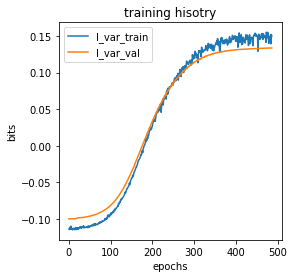

In [28]:
# Show training history
print('On test data:')
# x_test = test_df['x'].values
# y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
fig.savefig('pngs/Titeseq_MP/history.png',dpi=200,bbox_inches='tight')

In [53]:
#plt.scatter(theta_lc_init.ravel(),gpmap.weights[1].numpy().ravel(),c='blue',s=10)

In [30]:
theta = np.squeeze(gpmap.weights[1].numpy())
theta_df = pd.DataFrame(theta,columns=model.alphabet)

# theta_0 = np.squeeze(gpmap.weights[1].numpy())[0]
# theta_0_df = pd.DataFrame(theta_0,columns=model.alphabet)

# theta_1 = np.squeeze(gpmap.weights[1].numpy())[1]
# theta_1_df = pd.DataFrame(theta_1,columns=model.alphabet)

In [31]:
phi = gpmap.x_to_phi(x_test)

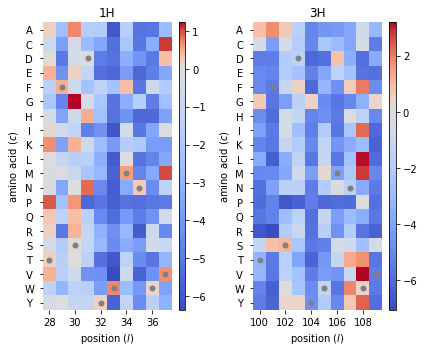

In [32]:
fig, axs = plt.subplots(1,2, figsize=(6,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs[0],
                                values=theta_df.loc[0:9].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H')

heatmap_ax, cb = mavenn.heatmap(ax=axs[1],
                                values=theta_df.loc[10:20].values,
                                alphabet=model.alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':25},
                                cmap='coolwarm',
                                cbar=True,
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(100,110,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'3H')

fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/GP_map.png',dpi=200,bbox_inches='tight',facecolor='white')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_46929/1791248001.py:46: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cb = plt.colorbar(im)


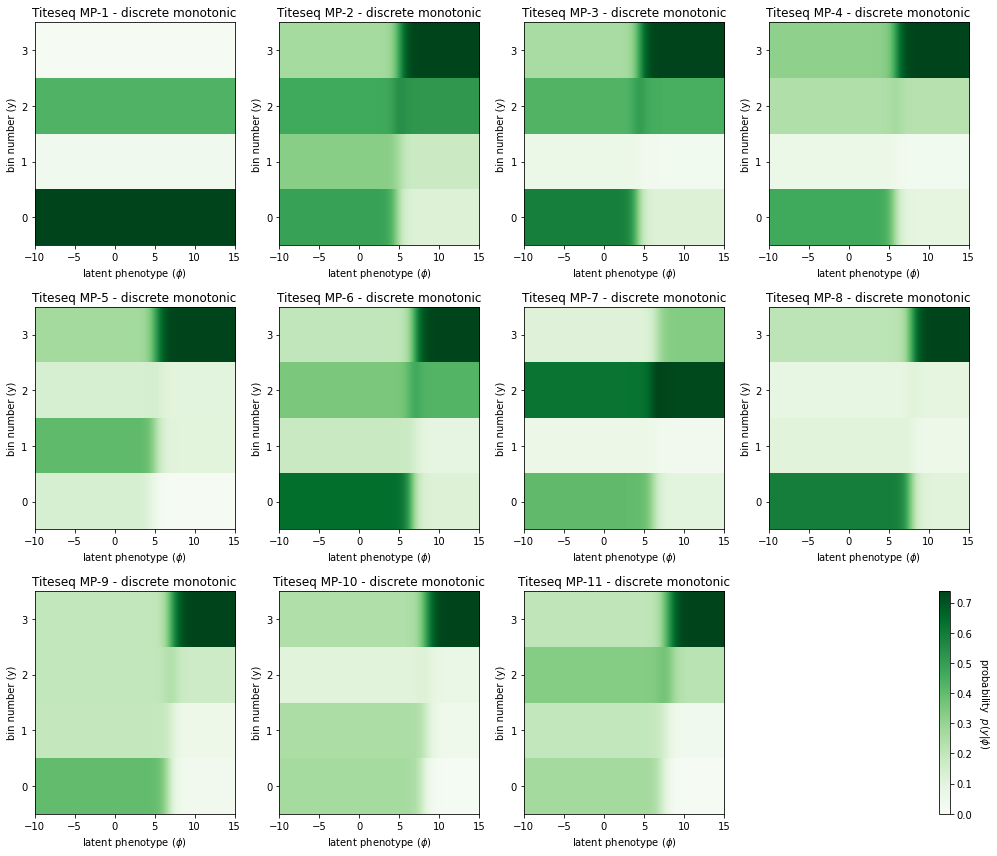

In [33]:
# Create grid in phi space
phi_lim = [-10, 15]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = TiteSeq_mp_list[0].Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values



# Create figure with two panels
fig, axs = plt.subplots(3,4,figsize=[14,12])

mp_counter = 0
for i in range(3):
    for j in range(4):
        

        if mp_counter==11:
            axs[i,j].axis('off')
            break
        measurement_process = TiteSeq_mp_list[mp_counter].p_of_y_given_phi(y_all, phi_grid)
        # Right panel: draw measurement process as heatmap
        ax = axs[i,j]

        im = ax.imshow(measurement_process,
                       cmap='Greens',
                       extent=phi_lim+y_lim,
                       vmin=0,
                       origin='lower',
                       interpolation='nearest',
                       aspect="auto")
        ax.set_yticks(y_all)
        ax.set_ylabel('bin number (y)')
        ax.set_xlabel('latent phenotype ($\phi$)')
        ax.set_title(f'Titeseq MP-{mp_counter+1} - discrete monotonic')
        mp_counter+=1
        
#         if mp_counter ==11:
#             cb = plt.colorbar(im,ax=ax)
#             cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")        
        
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()

fig.savefig('pngs/Titeseq_MP/MPs.png',dpi=200,bbox_inches='tight')


In [34]:
CDR1H_titeseq_df = pd.DataFrame(np.load('CDR1H.raw.heatmap.npy'),columns=model.alphabet)
CDR3H_titeseq_df = pd.DataFrame(np.load('CDR3H.raw.heatmap.npy'),columns=model.alphabet)

In [35]:
# # Manual Gauge fixing
#from mavenn.src.utils import _x_to_mat

def _x_to_mat1(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] ==
            np.array(alphabet)[np.newaxis, :]).astype(float)

def manual_WT_gauge(theta_lc,L,WT_seq,theta_0=0,model=model):

    C = model.C
    p_lc = _x_to_mat1(WT_seq, list(model.alphabet))

    theta_lclc = np.full(shape=(L, C, L, C), fill_value=np.nan)
    nan_mask_lclc = np.isnan(theta_lclc)
    theta_lclc[nan_mask_lclc] = 0
    _ = np.newaxis

    # Fix 0th order parameter
    fixed_theta_0 = theta_0 \
        + np.sum(p_lc * theta_lc) \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :])

    # Fix 1st order parameters
    fixed_theta_lc = theta_lc \
        - np.sum(theta_lc * p_lc, axis=1)[:, _] \
        + np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=(2, 3)) \
        - np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 2, 3))[:, _]

    # Fix 2nd order parameters
    fixed_theta_lclc = theta_lclc \
        - np.sum(theta_lclc * p_lc[:, :, _, _],
                 axis=1)[:, _, :, :] \
        - np.sum(theta_lclc * p_lc[_, _, :, :],
                 axis=3)[:, :, :, _] \
        + np.sum(theta_lclc * p_lc[:, :, _, _] * p_lc[_, _, :, :],
                 axis=(1, 3))[:, _, :, _]  
    
    return fixed_theta_lc
# np.save('theta_lc_AIE_gf',fixed_theta_lc)

In [36]:
CDR1H_titeseq_WT_gauge = manual_WT_gauge(CDR1H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][0:10],L=10)
CDR3H_titeseq_WT_gauge = manual_WT_gauge(CDR3H_titeseq_df.values,WT_seq=model.x_stats['consensus_seq'][10:20],L=10)


In [37]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

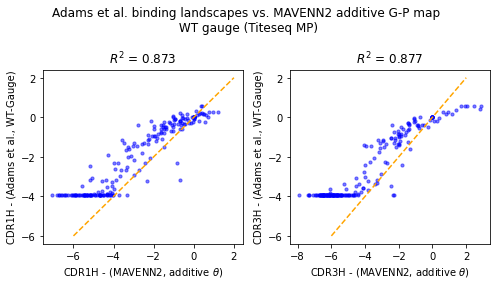

In [99]:
theta_lc_consensus_df.loc[0:9]
fig, axs = plt.subplots(1,2,figsize=(7,4))
ax = axs[0]

Rsq = np.corrcoef(CDR1H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[0:9].values.ravel())[0,1]**2

lims = [-6,2]
ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[0:9].values.ravel(),-CDR1H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR1H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR1H - (MAVENN2, additive $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(CDR3H_titeseq_WT_gauge.ravel(),theta_lc_consensus_df.loc[10:20].values.ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.plot(lims,lims,'--',color='orange')
ax.scatter(theta_lc_consensus_df.loc[10:20].values.ravel(),-CDR3H_titeseq_WT_gauge.ravel(),c='blue',s=10,alpha=0.5)
ax.set_ylabel('CDR3H - (Adams et al., WT-Gauge)')
ax.set_xlabel('CDR3H - (MAVENN2, additive $\\theta$)')

fig.suptitle('Adams et al. binding landscapes vs. MAVENN2 additive G-P map \n WT gauge (Titeseq MP) ')
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Adams_vs_mavenn_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


In [39]:
# np.save('models/theta_0_TS.npy',model.model.get_weights()[0])
# np.save('models/theta_lc_TS.npy',model.model.get_weights()[1])
# np.save('models/theta_lc_consensus_TS_df.npy', theta_lc_consensus_df.values)

In [40]:
#theta_lc_TS = np.load('models/theta_lc_consensus_TS_df.npy')
theta_lc_DM = np.load('models/theta_lc_consensus_DM_df.npy')



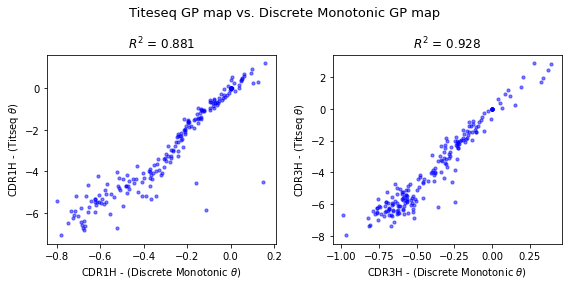

In [41]:
fig, axs = plt.subplots(1,2,figsize=(8,4))

ax = axs[0]

Rsq = np.corrcoef(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[0:10].ravel(),theta_lc[0:10].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR1H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR1H - (Titseq $\\theta$)')

ax = axs[1]
Rsq = np.corrcoef(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel())[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(theta_lc_DM[10:20].ravel(),theta_lc[10:20].ravel(),c='blue',s=10,alpha=0.5)
ax.set_xlabel('CDR3H - (Discrete Monotonic $\\theta$)')
ax.set_ylabel('CDR3H - (Titseq $\\theta$)')

fig.suptitle('Titeseq GP map vs. Discrete Monotonic GP map',fontsize=13)
fig.tight_layout()
fig.savefig('pngs/Titeseq_MP/Titeseq_vs_Discrete_mono_GP_map_WT_WT_gauge.png',
            facecolor='white', edgecolor='none',
            dpi=200,bbox_inches='tight')


### Compute K_D values

In [42]:
#phi = gpmap.x_to_phi(x_test)

a = TiteSeq_mp_list[0].get_weights()[0][0]

def mu_of_phi(c, 
              a=a,
              phi=phi,
              mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    
    return mu_of_phi
    
def Ka_of_c(c, 
            a=a,
            phi=phi,
            mu_neg=mu_neg):

    K_a_of_phi = 10**(phi)
    B = 10**(mu_neg)
    A = 10**(a)
    
    mu_of_phi = np.log10(A*(c*K_a_of_phi)/(1+c*K_a_of_phi)+B)
    #return B-10**
    
    return mu_of_phi


In [43]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [44]:
def _x_to_mat(x, alphabet):
    return (np.array(list(x))[:, np.newaxis] == alphabet[np.newaxis, :]).astype(float)

In [45]:
model.x_stats['consensus_seq']

'TFSDYWMNWVGSYYGMDYWG'

In [46]:
WT_seq = model.x_stats['consensus_seq']

single_mutants = []

for idx,WT_char in enumerate(WT_seq):
    #print(idx)
    for mutant in model.alphabet:
#         if mutant==WT_seq[idx]:
#             continue
#         else:
        temp_WT_list = list(WT_seq)
        temp_WT_list[idx] = mutant
        single_mutant = ''.join(temp_WT_list)
        single_mutants.append(single_mutant)
            

In [47]:
phi_single_mutants = gpmap.x_to_phi(single_mutants)

In [64]:
Adams_ordering = ['E','D','R','K','H','P','C','Q','N','T','S','W','Y','F','M','L','I','V','A','G']

Text(0.5, 1.0, '1H - (Adams)')

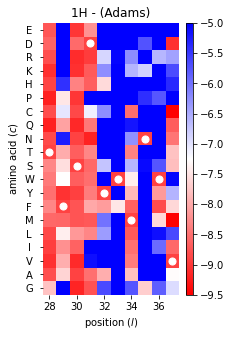

In [159]:
CDR1H_titeseq_df
fig, axs = plt.subplots(1,1, figsize=(2.7,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=axs,
                                values=(CDR1H_titeseq_df[Adams_ordering].values),
                                alphabet=Adams_ordering,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'white', 's':50},
                                cmap='bwr_r',
                                cbar=True,
                                #clim=[10**-6,10**-5],
                                #cmap_size='2%',
                                #cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
heatmap_ax.set_xticks(np.arange(0,10,2))
heatmap_ax.set_xticklabels(np.arange(28,38,2))
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'1H - (Adams)')

/var/folders/kx/rdhxdz2129n1dd59rnympr580000gp/T/ipykernel_46929/1630814955.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


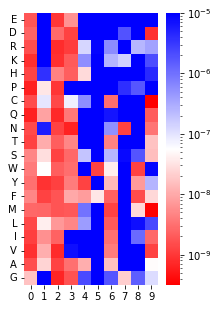

In [179]:
fig, ax = plt.subplots(figsize=(3,5))
from matplotlib.colors import LogNorm

from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-10**-9, vcenter=10**-6.5, vmax=10**-5)
#pcolormesh(your_data, cmap="coolwarm", norm=divnorm)

data = 10**(CDR1H_titeseq_df[Adams_ordering].values.ravel())
log_norm = LogNorm(vmin=min(data), vmax=max(data))
norm = plt.Normalize(-10**-9.5,10**-5.5,clip=False)

sns.heatmap(10**(CDR1H_titeseq_df[Adams_ordering].values.T),
            ax=ax,
            cmap='bwr_r',
            norm=log_norm
            #norm=divnorm
            #norm=norm
           )

ax.set_yticklabels(Adams_ordering,rotation=0)
fig.show()

Text(0.5, 0, '$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\\phi)}^{-1}$')

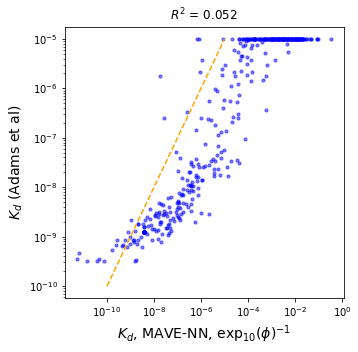

In [225]:
fig, ax = plt.subplots(figsize=(5,5))


lims=[10**-10,10**-5]
ax.plot(lims,lims,'--',color='orange')

Rsq = np.corrcoef(1/(10**((phi_single_mutants))),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()))[0,1]**2

ax.set_title(f'$R^2$ = {Rsq:.3f}')
ax.scatter(1/10**((phi_single_mutants)),
            10**(pd.concat([CDR1H_titeseq_df,CDR3H_titeseq_df]).values.ravel()),
            color='blue',s=10,alpha=0.5)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel('$K_d$ (Adams et al)',fontsize=14)
ax.set_xlabel('$K_d$, MAVE-NN, ${{\\rm exp}_{10}(\phi)}^{-1}$',fontsize=14)


In [49]:
phi_WT = gpmap.x_to_phi(WT_seq)

$K_a(\phi)$ = ${\rm exp}_{10}(\phi)$ \
$K_d$ = ${K_a}^{-1}$

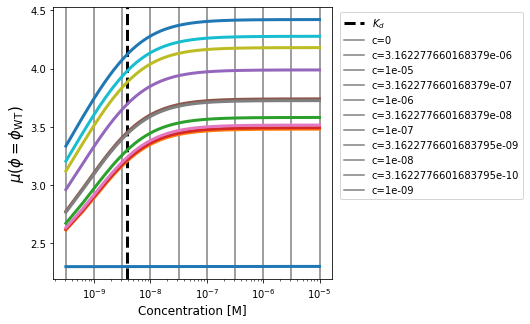

In [221]:
fig, ax = plt.subplots(figsize=(5,5))

for a in as_list:
    ax.plot(cs_,(mu_of_phi(c=cs_,a=a,phi=phi_WT)),lw=3,zorder=10)    
ax.set_xlabel('Concentration [M]',fontsize=12)
ax.set_ylabel('$\mu(\phi = \phi_{\\rm WT})$',fontsize=15)

ax.axvline(1/(10**phi_WT),ls='--',color='black',lw=3,label='$K_d$')
for c in cs2:
    ax.axvline(c,c='gray',zorder=-10,label=f'c={c}')

ax.set_xscale('log')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left')

Text(0, 0.5, '$\\mu(\\phi)$')

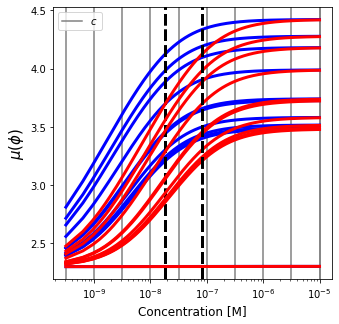

In [281]:
plt.figure(figsize=(5,5))

cs_ = np.arange(10**-9.5,10**-5,10**(-9.5))

as_list = []

for a_idx in range(len(TiteSeq_mp_list)):
    as_list.append(TiteSeq_mp_list[a_idx].get_weights()[0][0])

random_phi_list = np.random.choice(np.arange(0,len(phi)),size=10)

#for _ in random_phi_list:
for _ in [84,86]:
    
    if _ == 84:
        color='blue'
    elif _ == 86:
        color='red'
    for a in as_list:
        plt.plot(cs_,mu_of_phi(c=cs_,a=a,phi=phi[_]),lw=3,color=color)
        plt.axvline(1/(10**phi[_]),ls='--',color='black',lw=3)
    
for c in cs:
    plt.axvline(c,c='gray',zorder=-10)
    
plt.axvline(cs[-1],c='gray',zorder=-10,label=f'$c$')    
plt.legend()
#plt.plot(cs_,mu_of_phi(c=cs_,phi=phi_WT),'--',lw=4,zorder=10,color='black',label='WT')    
plt.xlabel('Concentration [M]',fontsize=12)
plt.xscale('log')
#plt.yscale('log')
plt.ylabel('$\mu(\phi)$',fontsize=15)
#plt.ylim(0,4)

In [ ]:
37
314
295
84
266
479
300
483
86
453